In [ ]:
# Standard library
import os
import re

# Scientific computing and data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Statistics and mathematics
from scipy.spatial import ConvexHull
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist
from scipy import stats

# Machine learning and model evaluation
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    recall_score,
    accuracy_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
    make_scorer,
    precision_recall_curve,
    auc,
    silhouette_score,
)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

# Imbalanced-learn
from imblearn.over_sampling import SVMSMOTE
from imblearn.pipeline import Pipeline

# Intel extensions for scikit-learn
from sklearnex import patch_sklearn

# Model interpretability
import shap

from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Enable scikit-learn acceleration
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [132]:
# Get the directory path of the current script
script_dir = os.path.dirname(os.path.abspath('Brucella-strain-zoonotic-predict-model.ipynb'))

# Construct absolute paths to data files
gene_presence_absence_csv_path = os.path.join(script_dir, 'Data', 'gene_presence_absence.csv')
significant_genes_csv_path = os.path.join(script_dir, 'Data', 'Significant_genes.csv')
trait_csv_path = os.path.join(script_dir, 'Data', 'trait.csv')

# Load and preprocess gene presence-absence matrix
gene_presence_absence = pd.read_csv(gene_presence_absence_csv_path, index_col=0)
gene_presence_absence = gene_presence_absence.T

# Encode gene presence (1) and absence (0)
gene_presence_absence.replace(to_replace='[^0]', value=1, regex=True, inplace=True)
gene_presence_absence.fillna(0, inplace=True)

# Load and filter significant genes
col_names = pd.read_csv(significant_genes_csv_path, header=None).iloc[1:, 0].tolist()
dataset = gene_presence_absence.loc[:, col_names]

# Integrate zoonotic potential labels
trait = pd.read_csv(trait_csv_path)
dataset["zoonotic"] = dataset.index.map(trait.set_index(trait.columns[0])['human'])

# Clean metadata (remove the first 13 rows)
dataset = dataset.drop(dataset.index[0:13])

# Split dataset by zoonotic potential label availability
subset_create_model = dataset[dataset.zoonotic.notnull()].copy()
subset_create_model['ID'] = subset_create_model.index
subset_create_model = subset_create_model.reset_index(drop=True)

subset_zoonotic_predict = dataset[dataset.zoonotic.isnull()].copy()
subset_zoonotic_predict['ID'] = subset_zoonotic_predict.index
subset_zoonotic_predict = subset_zoonotic_predict.reset_index(drop=True)

Columns (14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,2

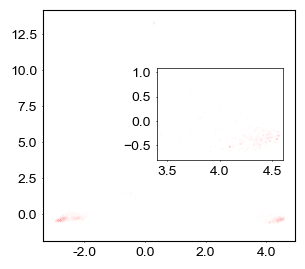

In [4]:
# Select features
features = subset_create_model.iloc[:, :-2]

#Performed analysis with the PCA unsupervised machine learning algorithm
pca = PCA(n_components=2)
reduced_features_pca = pca.fit_transform(features)
reduced_df_pca = pd.DataFrame(reduced_features_pca, columns=['PC1', 'PC2'])
reduced_df_pca['zoonotic'] = subset_create_model['zoonotic']

#Visualization
plt.rcParams['font.family']='Arial'
plt.figure(figsize=(3.25, 3))

# Scatter plot for each class
non_zoonotic = reduced_df_pca[reduced_df_pca['zoonotic'] == 0]
zoonotic = reduced_df_pca[reduced_df_pca['zoonotic'] == 1]
plt.scatter(non_zoonotic['PC1'], non_zoonotic['PC2'], c='#7db0e1', s=0.0001, label='Non-Zoonotic isolate')
plt.scatter(zoonotic['PC1'], zoonotic['PC2'], c='#ff6561', s=0.0001, label='Zoonotic isolate')

plt.rc('axes', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(axis='both', which='major', width=0.6, length=1)

# Format x-ticks
ticks = plt.xticks()[0][1:-1]
labels = ["{:.1f}".format(tick) for tick in ticks]
plt.xticks(ticks, labels)

# Inset axes for zoomed region
zoom_x_start, zoom_x_end = 3.4, 4.6
zoom_y_start, zoom_y_end = -0.8, 1.1
ax = plt.gca()
axins = ax.inset_axes([0.45, 0.35, 0.5, 0.4])

zoom_mask = (
    (reduced_df_pca['PC1'] >= zoom_x_start) & (reduced_df_pca['PC1'] <= zoom_x_end) &
    (reduced_df_pca['PC2'] >= zoom_y_start) & (reduced_df_pca['PC2'] <= zoom_y_end)
)
zoomed = reduced_df_pca[zoom_mask]
axins.scatter(
    zoomed['PC1'],
    zoomed['PC2'],
    c=zoomed['zoonotic'].map({0: '#7db0e1', 1: '#ff6561'}),
    s=0.0002
)
axins.set_xlim(zoom_x_start, zoom_x_end)
axins.set_ylim(zoom_y_start, zoom_y_end)
axins.tick_params(axis='both', which='major', labelsize=10)
axins.set_yticks([-0.5, 0, 0.5, 1])
axins.set_xticks([3.5, 4.0, 4.5])
axins.tick_params(axis='x', which='major', length=1, width=0.6)
axins.tick_params(axis='y', which='major', length=1, width=0.6)
for spine in axins.spines.values():
    spine.set_linewidth(0.5)
plt.show()

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than

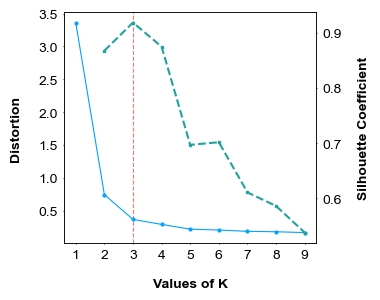

In [5]:
#Determining the Optimal Number of Clusters 

K=range(1,10)
mean_distortions=[]
silhouette_scores=[]
for k in K:
    kmeans_ES=KMeans(n_clusters=k, random_state=1, n_init='auto')
    kmeans_ES.fit(reduced_features_pca)
    # Calculate mean distortion
    mean_distortion = np.mean(
        np.min(
            cdist(reduced_features_pca, kmeans_ES.cluster_centers_, 'euclidean'),
            axis=1
        )
    )
    mean_distortions.append(mean_distortion)
    # Calculate silhouette score for k > 1
    if k > 1:
        labels = kmeans_ES.predict(reduced_features_pca)
        silhouette_scores.append(silhouette_score(reduced_features_pca, labels))

# Visualization
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(3.25, 3))
plt.rc('axes', linewidth=0.5)

# Plot mean distortion
plt.axvline(x=3, ymin=0, ymax=1, color='#FF7768', linestyle='--', lw=0.8)
plt.plot(K, mean_distortions, 'o-', color='#00A3FF', lw=0.8, markersize=2)
plt.xlabel('Values of K', fontsize=10, labelpad=12, fontweight='bold')
plt.ylabel('Distortion', fontsize=10, labelpad=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(axis='both', which='major', width=0.6, length=1)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])

# Plot silhouette score on secondary y-axis
ax2 = plt.gca().twinx()
ax2.plot(
    list(K)[1:], silhouette_scores,
    c='#20a39e', ls='--', marker='s', markersize=2
)
ax2.set_yticks([0.6, 0.7, 0.8, 0.9])
ax2.tick_params(axis='y', which='major', width=0.6, length=1)
ax2.set_yticklabels(['0.6', '0.7', '0.8', '0.9'])
ax2.set_ylabel('Silhouette Coefficient', fontsize=10, labelpad=12, fontweight='bold')
plt.show()

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.


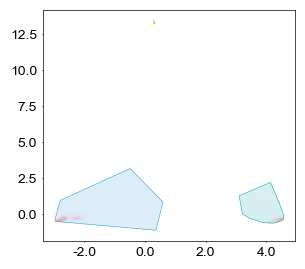

In [6]:
#Performed analysis with the k-means unsupervised machine learning algorithm
kmeans = KMeans(n_clusters=3, random_state=1, n_init="auto").fit(reduced_features_pca)

# Assign cluster labels
kmeans_labels = kmeans.predict(reduced_features_pca)
reduced_df_pca['kmeans_label'] = kmeans_labels

# Visualization
plt.rcParams['font.family']='Arial'
plt.figure(figsize=(3.25, 3))

# Draw convex hulls for each cluster
hull_facecolors = ['#d8eff2', '#dcedf9', '#faf1d7']
hull_edgecolors = ['#00afbb', '#2e9fdf', '#e7b800']
for label in range(3):
    points = reduced_df_pca[reduced_df_pca['kmeans_label'] == label][['PC1', 'PC2']].values
    if len(points) >= 3:  # ConvexHull requires at least 3 points
        hull = ConvexHull(points)
        plt.fill(
            points[hull.vertices, 0],
            points[hull.vertices, 1],
            facecolor=hull_facecolors[label],
            edgecolor=hull_edgecolors[label],
            linewidth=0.4
        )

# Scatter plot for zoonotic and non-zoonotic isolates
plt.scatter(
    reduced_df_pca[reduced_df_pca['zoonotic'] == 0]['PC1'],
    reduced_df_pca[reduced_df_pca['zoonotic'] == 0]['PC2'],
    c='#7db0e1', s=0.0001, label='Non-Zoonotic isolate'
)
plt.scatter(
    reduced_df_pca[reduced_df_pca['zoonotic'] == 1]['PC1'],
    reduced_df_pca[reduced_df_pca['zoonotic'] == 1]['PC2'],
    c='#ff6561', s=0.0001, label='Zoonotic isolate'
)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(axis='both', which='major', width=0.6, length=1)
plt.rc('axes', linewidth=0.5)

# Format x-ticks
ticks = plt.xticks()[0][1:-1]
labels = ["{:.1f}".format(tick) for tick in ticks]
plt.xticks(ticks, labels)
plt.show()

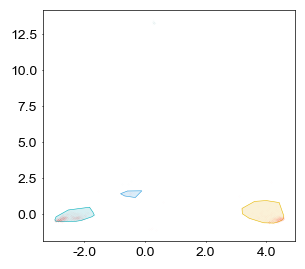

In [7]:
#Performed analysis with the DBSCAN unsupervised machine learning algorithm
dbscan = DBSCAN().fit(reduced_features_pca)
reduced_df_pca['dbscan_label'] = dbscan.labels_

#Visualization
plt.rcParams['font.family']='Arial'
plt.figure(figsize=(3.25, 3))

# Draw convex hulls for each cluster
hull_facecolors = ['#d8eff2', '#dcedf9', '#faf1d7']
hull_edgecolors = ['#00afbb', '#2e9fdf', '#e7b800']
for label in range(3):
    points = reduced_df_pca[reduced_df_pca['dbscan_label'] == label][['PC1', 'PC2']].values
    if len(points) >= 3:  # ConvexHull requires at least 3 points
        hull = ConvexHull(points)
        plt.fill(
            points[hull.vertices, 0],
            points[hull.vertices, 1],
            facecolor=hull_facecolors[label],
            edgecolor=hull_edgecolors[label],
            linewidth=0.4
        )

# Scatter plot for zoonotic and non-zoonotic isolates
plt.scatter(
    reduced_df_pca[reduced_df_pca['zoonotic'] == 0]['PC1'],
    reduced_df_pca[reduced_df_pca['zoonotic'] == 0]['PC2'],
    c='#7db0e1', s=0.0001, label='Non-Zoonotic isolate'
)
plt.scatter(
    reduced_df_pca[reduced_df_pca['zoonotic'] == 1]['PC1'],
    reduced_df_pca[reduced_df_pca['zoonotic'] == 1]['PC2'],
    c='#ff6561', s=0.0001, label='Zoonotic isolate'
)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(axis='both', which='major', width=0.6, length=1)
plt.rc('axes', linewidth=0.5)

# Format x-ticks
ticks = plt.xticks()[0][1:-1]
labels = ["{:.1f}".format(tick) for tick in ticks]
plt.xticks(ticks, labels)
plt.show()

In [17]:
# Define AUPRC (Area Under Precision-Recall Curve) Scoring Function
def auprc_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

# Split dataset into training (50%) and test (50%) sets
seed_start = 1
seed_end = 101
seed_list = range(seed_start, seed_end)
X = subset_create_model.drop(['zoonotic','ID'],axis = 1)
Y = subset_create_model.zoonotic
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.5, random_state=1, stratify=Y
)

# Define scoring metrics
scoring_set = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score),
    'matthews_corrcoef': make_scorer(matthews_corrcoef),
    'f1': make_scorer(f1_score),
    'auprc': make_scorer(auprc_score)
}

# Initialize metric lists for Random Forest
metrics_list_rf_acc = []
metrics_list_rf_rec = []
metrics_list_rf_mcc = []
metrics_list_rf_auc = []
metrics_list_rf_f1 = []
metrics_list_rf_auprc = []
models_rf = []

rf_param_grid = {
    'clf__n_estimators': [50, 100, 200, 400],
    'clf__max_depth': [10, 15, 20],
    'clf__min_samples_split': [2, 3, 5, 7, 10],
    'clf__min_samples_leaf': [1, 3, 5, 7, 10],
}

# Initialize metric lists for Decision Tree
metrics_list_dtc_acc = []
metrics_list_dtc_rec = []
metrics_list_dtc_mcc = []
metrics_list_dtc_auc = []
metrics_list_dtc_f1 = []
metrics_list_dtc_auprc = []
models_dtc = []

dtc_param_grid = {
    'clf__max_depth': [10, 15, 20],
    'clf__min_samples_split': [2, 3, 5, 7, 10],
    'clf__min_samples_leaf': [1, 3, 5, 7, 10]
}

# Initialize metric lists for SVM
metrics_list_svm_acc = []
metrics_list_svm_rec = []
metrics_list_svm_mcc = []
metrics_list_svm_auc = []
metrics_list_svm_f1 = []
metrics_list_svm_auprc = []
models_svm = []

svm_param_grid = {'clf__C': [0.005, 0.01, 0.1, 1, 10, 100],
'clf__kernel': ['rbf','poly','linear'],
'clf__degree': [0, 1, 2, 5, 10]}

# Initialize metric lists for KNN
metrics_list_knn_acc = []
metrics_list_knn_rec = []
metrics_list_knn_mcc = []
metrics_list_knn_auc = []
metrics_list_knn_f1 = []
metrics_list_knn_auprc = []
models_knn = []

knn_param_grid = {
    'clf__n_neighbors': [1, 3, 5, 7, 11, 21],
    'clf__p': [1, 2]
}

# Initialize metric lists for MLP
metrics_list_mlp_acc = []
metrics_list_mlp_rec = []
metrics_list_mlp_mcc = []
metrics_list_mlp_auc = []
metrics_list_mlp_f1 = []
metrics_list_mlp_auprc = []
models_mlp = []

mlp_param_grid = {
    'clf__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'clf__activation': ['relu', 'logistic'],
    'clf__alpha': [0.0001, 0.001, 0.01],
    'clf__max_iter': [300, 400, 600]
}

In [19]:
# SVM model training and evaluation with SVMSMOTE for class imbalance
for seed in seed_list:
    # Build a pipeline: SVMSMOTE for oversampling, SVC for classification
    pipe = Pipeline([
        ('svmsmote', SVMSMOTE(random_state=seed, k_neighbors=2)),
        ('clf', SVC(class_weight='balanced', probability=True, random_state=seed))
    ])
   
    # Stratified K-Fold cross-validation to maintain label proportions in each fold
    skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

    # Grid search for hyperparameter tuning with multiple scoring metrics
    grid_search = GridSearchCV(
        pipe, svm_param_grid, cv=skfold, 
        n_jobs=-1, scoring = scoring_set, refit='matthews_corrcoef'
    )
    
    # Fit the pipeline to the training data
    grid_search.fit(X_train, Y_train)

    # Collect the best scores for each metric from the cross-validation results
    metrics_list_svm_acc.append(grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])
    metrics_list_svm_rec.append(grid_search.cv_results_['mean_test_recall'][grid_search.best_index_])
    metrics_list_svm_mcc.append(grid_search.cv_results_['mean_test_matthews_corrcoef'][grid_search.best_index_])
    metrics_list_svm_auc.append(grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_])
    metrics_list_svm_f1.append(grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
    metrics_list_svm_auprc.append(grid_search.cv_results_['mean_test_auprc'][grid_search.best_index_])
    models_svm.append(grid_search.best_params_)
    
# Print average metrics for SVM model
print(f"Average accuracy score：{np.mean(metrics_list_svm_acc)}")
print(f"Average recall score：{np.mean(metrics_list_svm_rec)}")
print(f"Average MCC score：{np.mean(metrics_list_svm_mcc)}")
print(f"Average AUC score：{np.mean(metrics_list_svm_auc)}")
print(f"Average F1 score：{np.mean(metrics_list_svm_f1)}")
print(f"Average AUPRC score：{np.mean(metrics_list_svm_auprc)}")

Average accuracy score：0.9909750566893426
Average recall score：0.99995337995338
Average MCC score：0.7820603770121803
Average AUC score：0.8212266899766899
Average F1 score：0.9953978785861528
Average AUPRC score：0.9954487079250136


In [20]:
# Random Forest Classifier model training and evaluation with SVMSMOTE for class imbalance
for seed in seed_list:
    # Build a pipeline: SVMSMOTE for oversampling, RandomForestClassifier for classification
    pipe = Pipeline([
        ('svmsmote', SVMSMOTE(random_state=seed, k_neighbors=2)),
        ('clf', RandomForestClassifier(random_state=seed, class_weight='balanced', n_jobs=-1))
    ])

    # Stratified K-Fold cross-validation to maintain label proportions in each fold
    skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

    # Grid search for hyperparameter tuning with multiple scoring metrics
    grid_search = GridSearchCV(
        pipe, rf_param_grid, cv=skfold, 
        n_jobs=-1, scoring=scoring_set, refit='matthews_corrcoef'
    )

    # Fit the pipeline to the training data
    grid_search.fit(X_train, Y_train)

    # Collect the best scores for each metric from the cross-validation results
    metrics_list_rf_acc.append(grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])
    metrics_list_rf_rec.append(grid_search.cv_results_['mean_test_recall'][grid_search.best_index_])
    metrics_list_rf_mcc.append(grid_search.cv_results_['mean_test_matthews_corrcoef'][grid_search.best_index_])
    metrics_list_rf_auc.append(grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_])
    metrics_list_rf_f1.append(grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
    metrics_list_rf_auprc.append(grid_search.cv_results_['mean_test_auprc'][grid_search.best_index_])
    models_rf.append(grid_search.best_params_)

# Print average metrics for Random Forest Classifier model
print(f"Average accuracy score：{np.mean(metrics_list_rf_acc)}")
print(f"Average recall score：{np.mean(metrics_list_rf_rec)}")
print(f"Average MCC score：{np.mean(metrics_list_rf_mcc)}")
print(f"Average AUC score：{np.mean(metrics_list_rf_auc)}")
print(f"Average F1 score：{np.mean(metrics_list_rf_f1)}")
print(f"Average AUPRC score：{np.mean(metrics_list_rf_auprc)}")


Average accuracy score：0.9868934240362813
Average recall score：0.9953018971768971
Average MCC score：0.7279463095665331
Average AUC score：0.8272342819217819
Average F1 score：0.993279641840506
Average AUPRC score：0.995615467907093


In [21]:
# Decision Tree model training and evaluation with SVMSMOTE for class imbalance
for seed in seed_list:
    # Build a pipeline: SVMSMOTE for oversampling, DecisionTreeClassifier for classification
    pipe = Pipeline([
        ('svmsmote', SVMSMOTE(random_state=seed, k_neighbors=2)),
        ('clf', DecisionTreeClassifier(random_state=seed, class_weight='balanced'))
    ])

    # Stratified K-Fold cross-validation to maintain label proportions in each fold
    skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

    # Grid search for hyperparameter tuning with multiple scoring metrics
    grid_search = GridSearchCV(
        pipe, dtc_param_grid, cv=skfold, 
        n_jobs=-1, scoring=scoring_set, refit='matthews_corrcoef'
    )

    # Fit the pipeline to the training data
    grid_search.fit(X_train, Y_train)

    # Collect the best scores for each metric from the cross-validation results
    metrics_list_dtc_acc.append(grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])
    metrics_list_dtc_rec.append(grid_search.cv_results_['mean_test_recall'][grid_search.best_index_])
    metrics_list_dtc_mcc.append(grid_search.cv_results_['mean_test_matthews_corrcoef'][grid_search.best_index_])
    metrics_list_dtc_auc.append(grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_])
    metrics_list_dtc_f1.append(grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
    metrics_list_dtc_auprc.append(grid_search.cv_results_['mean_test_auprc'][grid_search.best_index_])
    models_dtc.append(grid_search.best_params_)

# Print average metrics for Decision Tree model
print(f"Average accuracy score：{np.mean(metrics_list_dtc_acc)}")
print(f"Average recall score：{np.mean(metrics_list_dtc_rec)}")
print(f"Average MCC score：{np.mean(metrics_list_dtc_mcc)}")
print(f"Average AUC score：{np.mean(metrics_list_dtc_auc)}")
print(f"Average F1 score：{np.mean(metrics_list_dtc_f1)}")
print(f"Average AUPRC score：{np.mean(metrics_list_dtc_auprc)}")

Average accuracy score：0.9858956916099774
Average recall score：0.9946785159285157
Average MCC score：0.7126068871994861
Average AUC score：0.8198392579642578
Average F1 score：0.9927648850739327
Average AUPRC score：0.9954074756395493


In [22]:
# KNeighbors model training and evaluation with SVMSMOTE for class imbalance
for seed in seed_list:
    # Build a pipeline: SVMSMOTE for oversampling, KNeighborsClassifier for classification
    pipe = Pipeline([
        ('svmsmote', SVMSMOTE(random_state=seed, k_neighbors=2)),
        ('clf', KNeighborsClassifier(n_jobs=-1))
    ])

    # Stratified K-Fold cross-validation to maintain label proportions in each fold
    skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

    # Grid search for hyperparameter tuning with multiple scoring metrics
    grid_search = GridSearchCV(
        pipe, knn_param_grid, cv=skfold, 
        n_jobs=-1, scoring=scoring_set, refit='matthews_corrcoef'
    )

    # Fit the pipeline to the training data
    grid_search.fit(X_train, Y_train)

    # Collect the best scores for each metric from the cross-validation results
    metrics_list_knn_acc.append(grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])
    metrics_list_knn_rec.append(grid_search.cv_results_['mean_test_recall'][grid_search.best_index_])
    metrics_list_knn_mcc.append(grid_search.cv_results_['mean_test_matthews_corrcoef'][grid_search.best_index_])
    metrics_list_knn_auc.append(grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_])
    metrics_list_knn_f1.append(grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
    metrics_list_knn_auprc.append(grid_search.cv_results_['mean_test_auprc'][grid_search.best_index_])
    models_knn.append(grid_search.best_params_)

# Print average metrics for KNeighbors model
print(f"Average accuracy score：{np.mean(metrics_list_knn_acc)}")
print(f"Average recall score：{np.mean(metrics_list_knn_rec)}")
print(f"Average MCC score：{np.mean(metrics_list_knn_mcc)}")
print(f"Average AUC score：{np.mean(metrics_list_knn_auc)}")
print(f"Average F1 score：{np.mean(metrics_list_knn_f1)}")
print(f"Average AUPRC score：{np.mean(metrics_list_knn_auprc)}")

Average accuracy score：0.9832199546485262
Average recall score：0.9903072390572387
Average MCC score：0.6945683769813192
Average AUC score：0.8504313973063974
Average F1 score：0.9913611153303948
Average AUPRC score：0.9961521702526204


In [23]:
# MLP model training and evaluation with SVMSMOTE for class imbalance
for seed in seed_list:
    # Build a pipeline: SVMSMOTE for oversampling, MLPClassifier for classification
    pipe = Pipeline([
        ('svmsmote', SVMSMOTE(random_state=seed, k_neighbors=2)),
        ('clf', MLPClassifier(solver='lbfgs',random_state=seed))
    ])

    # Stratified K-Fold cross-validation to maintain label proportions in each fold
    skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

    # Grid search for hyperparameter tuning with multiple scoring metrics
    grid_search = GridSearchCV(
        pipe, mlp_param_grid, cv=skfold, 
        n_jobs=-1, scoring=scoring_set, refit='matthews_corrcoef'
    )

    # Fit the pipeline to the training data
    grid_search.fit(X_train, Y_train)

    # Collect the best scores for each metric from the cross-validation results
    metrics_list_mlp_acc.append(grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])
    metrics_list_mlp_rec.append(grid_search.cv_results_['mean_test_recall'][grid_search.best_index_])
    metrics_list_mlp_mcc.append(grid_search.cv_results_['mean_test_matthews_corrcoef'][grid_search.best_index_])
    metrics_list_mlp_auc.append(grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_])
    metrics_list_mlp_f1.append(grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
    metrics_list_mlp_auprc.append(grid_search.cv_results_['mean_test_auprc'][grid_search.best_index_])
    models_mlp.append(grid_search.best_params_)

# Print average metrics for MLP model
print(f"Average accuracy score：{np.mean(metrics_list_mlp_acc)}")
print(f"Average recall score：{np.mean(metrics_list_mlp_rec)}")
print(f"Average MCC score：{np.mean(metrics_list_mlp_mcc)}")
print(f"Average AUC score：{np.mean(metrics_list_mlp_auc)}")
print(f"Average F1 score：{np.mean(metrics_list_mlp_f1)}")
print(f"Average AUPRC score：{np.mean(metrics_list_mlp_auprc)}")

Average accuracy score：0.9883219954648526
Average recall score：0.9971637852887852
Average MCC score：0.736397025275056
Average AUC score：0.8213596704221702
Average F1 score：0.9940295673104164
Average AUPRC score：0.99543984443011


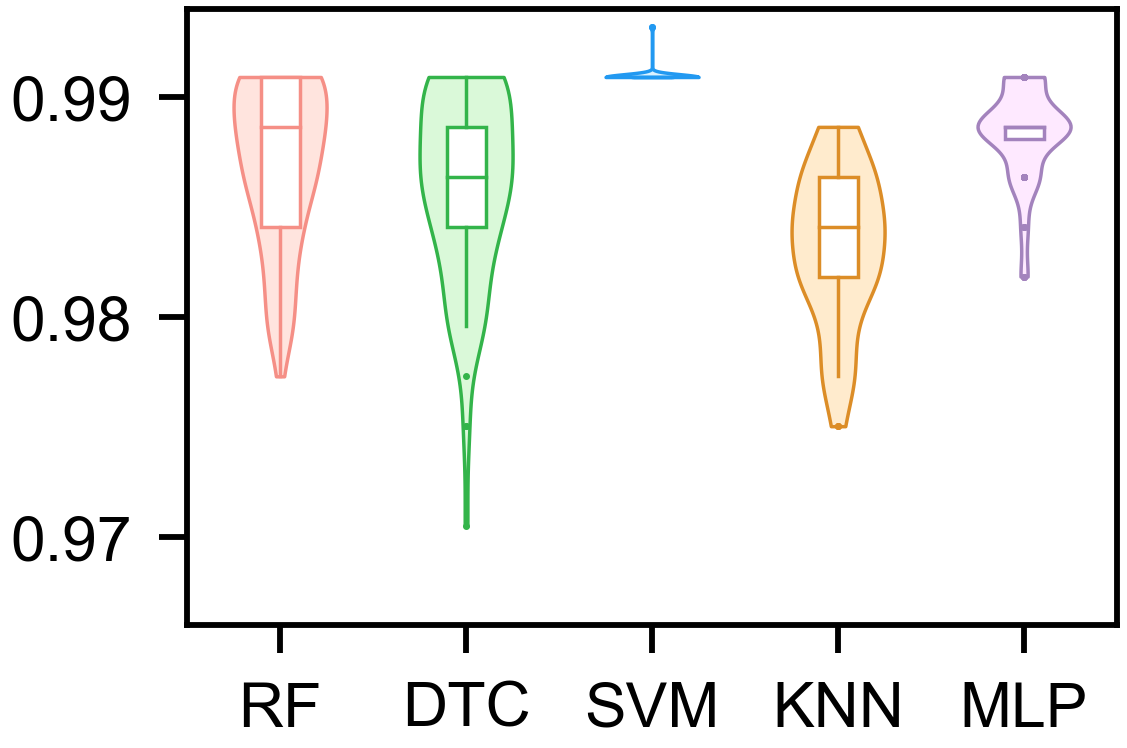

In [ ]:
# Accuracy violin and box plot for five classifiers

# Prepare accuracy score data for each model: RF, DTC, SVM, KNN, MLP
acc_data = [
    metrics_list_rf_acc,
    metrics_list_dtc_acc,
    metrics_list_svm_acc,
    metrics_list_knn_acc,
    metrics_list_mlp_acc
]

# Set font to Arial
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(12, 8))

# Draw violin plot for accuracy distributions
parts_violin = ax.violinplot(dataset=acc_data, showextrema=False)

# Define fill and edge colors for each model
colors = ['#FFE4DE', '#DAF9D9', '#DBF2FF', '#FFEBCD', '#FEE9FF']
edgecolors = ['#F58F86', '#33b44a', '#2299f1', '#dc8d27', '#a383bd']

# Set violin plot colors and styles
for pc, color, edgecolor in zip(parts_violin['bodies'], colors, edgecolors):
    pc.set_facecolor(color)
    pc.set_edgecolor(edgecolor)
    pc.set_linewidth(2.5)
    pc.set_alpha(1)

# Draw boxplot on top of violin plot for summary statistics
box = ax.boxplot(acc_data, patch_artist=True, widths=0.21, showcaps=False)
for patch, edgecolor in zip(box['boxes'], edgecolors):
    patch.set_edgecolor(edgecolor)
    patch.set_linewidth(2.5)
    patch.set_alpha(1)
    patch.set_facecolor('white')

# Set median line color
for median, color in zip(box['medians'], edgecolors):
    median.set_color(color)
    median.set_linewidth(2.5)
    median.set_alpha(1)

# Set whisker color and width
edgecolors_double = [
    '#F58F86', '#F58F86', '#33b44a', '#33b44a',
    '#2299f1', '#2299f1', '#dc8d27', '#dc8d27',
    '#a383bd', '#a383bd'
]
for whisker, color in zip(box['whiskers'], edgecolors_double):
    whisker.set_color(color)
    whisker.set_linewidth(2.5)

# Set outlier (flier) marker style and color
for flier, color in zip(box['fliers'], edgecolors):
    flier.set_marker('o')
    flier.set_markerfacecolor(color)
    flier.set_markeredgecolor(color)
    flier.set_markersize(4)

# Set x-axis tick labels for each classifier
xticklabels = ['RF', 'DTC', 'SVM', 'KNN', 'MLP']
ax.set_xticklabels(xticklabels)

# Set font size for x and y ticks
plt.xticks(fontsize=45)
plt.yticks(fontsize=45)

# Adjust axis tick width and length
plt.tick_params(axis='both', which='major', width=4.2, length=20)

# Set y-axis limits
plt.ylim(0.966, 0.994)

# Set y-axis major locator for tick intervals
y_major_locator = plt.MultipleLocator(0.01)
plt.gca().yaxis.set_major_locator(y_major_locator)

# Thicken all plot borders
plt.gca().spines['top'].set_linewidth(4.2)
plt.gca().spines['bottom'].set_linewidth(4.2)
plt.gca().spines['left'].set_linewidth(4.2)
plt.gca().spines['right'].set_linewidth(4.2)

# Increase distance between tick labels and axis
plt.gca().tick_params(axis='both', which='major', pad=20)
plt.show()

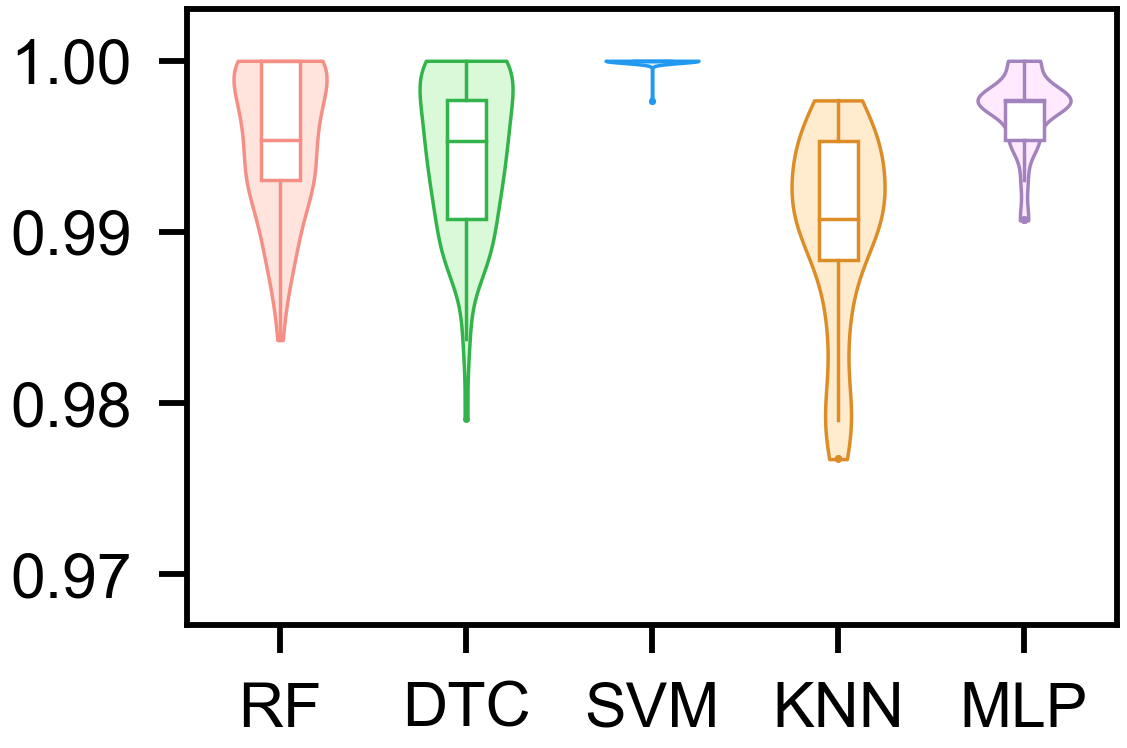

In [ ]:
# Recall violin and box plot for five classifiers

# Prepare recall score data for each model: RF, DTC, SVM, KNN, MLP
rec_data = [
    metrics_list_rf_rec,
    metrics_list_dtc_rec,
    metrics_list_svm_rec,
    metrics_list_knn_rec,
    metrics_list_mlp_rec
]

# Set font to Arial
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(12, 8))

# Draw violin plot for recall distributions
parts_violin = ax.violinplot(dataset=rec_data, showextrema=False)


# Define fill and edge colors for each model
colors = ['#FFE4DE', '#DAF9D9', '#DBF2FF', '#FFEBCD', '#FEE9FF']
edgecolors = ['#F58F86', '#33b44a', '#2299f1', '#dc8d27', '#a383bd']

# Set violin plot colors and styles
for pc, color, edgecolor in zip(parts_violin['bodies'], colors, edgecolors):
    pc.set_facecolor(color)
    pc.set_edgecolor(edgecolor)
    pc.set_linewidth(2.5)
    pc.set_alpha(1)

# Draw boxplot on top of violin plot for summary statistics
box = ax.boxplot(rec_data, patch_artist=True, widths=0.21, showcaps=False)
for patch, edgecolor in zip(box['boxes'], edgecolors):
    patch.set_edgecolor(edgecolor)
    patch.set_linewidth(2.5)
    patch.set_alpha(1)
    patch.set_facecolor('white')

# Set median line color
for median, color in zip(box['medians'], edgecolors):
    median.set_color(color)
    median.set_linewidth(2.5)
    median.set_alpha(1)

# Set whisker color and width
edgecolors_double = [
    '#F58F86', '#F58F86', '#33b44a', '#33b44a',
    '#2299f1', '#2299f1', '#dc8d27', '#dc8d27',
    '#a383bd', '#a383bd'
]
for whisker, color in zip(box['whiskers'], edgecolors_double):
    whisker.set_color(color)
    whisker.set_linewidth(2.5)

# Set outlier (flier) marker style and color
for flier, color in zip(box['fliers'], edgecolors):
    flier.set_marker('o')
    flier.set_markerfacecolor(color)
    flier.set_markeredgecolor(color)
    flier.set_markersize(4)

# Set x-axis tick labels for each classifier
xticklabels = ['RF', 'DTC', 'SVM', 'KNN', 'MLP']
ax.set_xticklabels(xticklabels)

# Set font size for x and y ticks
plt.xticks(fontsize=45)
plt.yticks(fontsize=45)

# Adjust axis tick width and length
plt.tick_params(axis='both', which='major', width=4.2, length=20)

# Set y-axis limits
plt.ylim(0.967, 1.003)

# Set y-axis major locator for tick intervals
y_major_locator = plt.MultipleLocator(0.01)
plt.gca().yaxis.set_major_locator(y_major_locator)

# Thicken all plot borders
plt.gca().spines['top'].set_linewidth(4.2)
plt.gca().spines['bottom'].set_linewidth(4.2)
plt.gca().spines['left'].set_linewidth(4.2)
plt.gca().spines['right'].set_linewidth(4.2)

# Increase distance between tick labels and axis
plt.gca().tick_params(axis='both', which='major', pad=20)
plt.show()

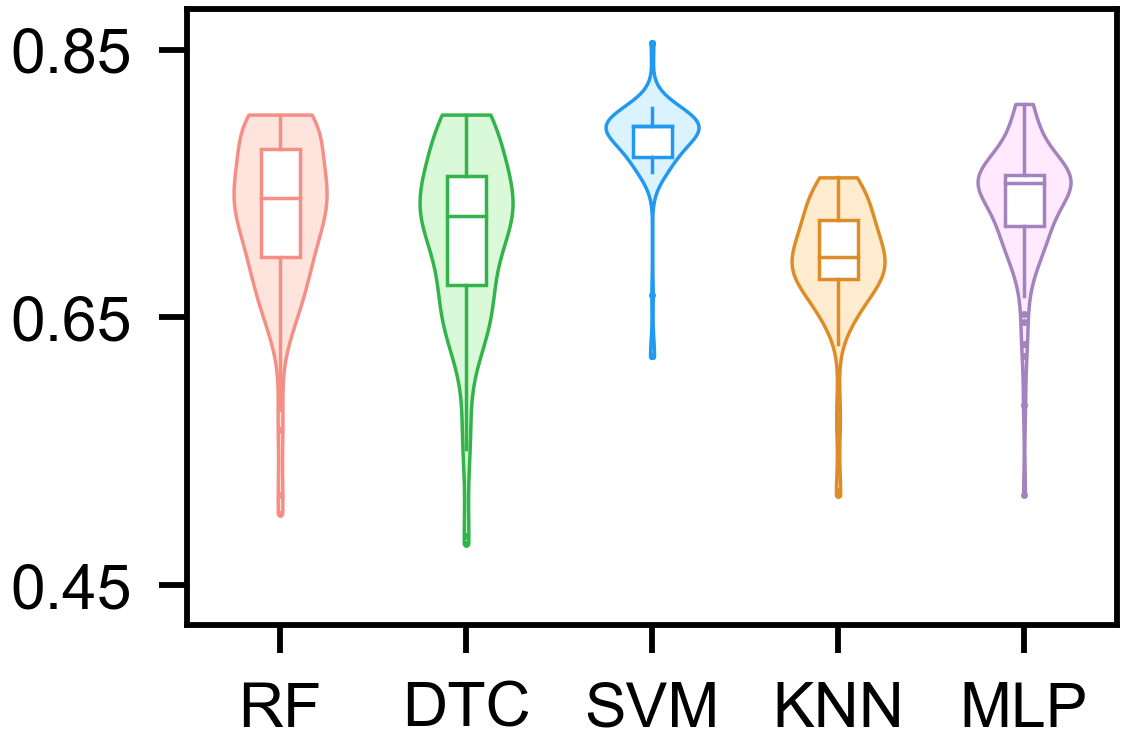

In [ ]:
# MCC violin and box plot for five classifiers

# Prepare MCC score data for each model: RF, DTC, SVM, KNN, MLP
mcc_data = [
    metrics_list_rf_mcc,
    metrics_list_dtc_mcc,
    metrics_list_svm_mcc,
    metrics_list_knn_mcc,
    metrics_list_mlp_mcc
]

# Set font to Arial
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(12, 8))

# Draw violin plot
parts_violin = ax.violinplot(dataset=mcc_data, showextrema=False)


# Define fill and edge colors for each model
colors = ['#FFE4DE', '#DAF9D9', '#DBF2FF', '#FFEBCD', '#FEE9FF']
edgecolors = ['#F58F86', '#33b44a', '#2299f1', '#dc8d27', '#a383bd']

# Set violin plot colors and styles
for pc, color, edgecolor in zip(parts_violin['bodies'], colors, edgecolors):
    pc.set_facecolor(color)
    pc.set_edgecolor(edgecolor)
    pc.set_linewidth(2.5)
    pc.set_alpha(1)

# Draw boxplot on top of violin plot for summary statistics
box = ax.boxplot(mcc_data, patch_artist=True, widths=0.21, showcaps=False)
for patch, edgecolor in zip(box['boxes'], edgecolors):
    patch.set_edgecolor(edgecolor)
    patch.set_linewidth(2.5)
    patch.set_alpha(1)
    patch.set_facecolor('white')

# Set median line color
for median, color in zip(box['medians'], edgecolors):
    median.set_color(color)
    median.set_linewidth(2.5)
    median.set_alpha(1)

# Set whisker color and width
edgecolors_double = [
    '#F58F86', '#F58F86', '#33b44a', '#33b44a',
    '#2299f1', '#2299f1', '#dc8d27', '#dc8d27',
    '#a383bd', '#a383bd'
]
for whisker, color in zip(box['whiskers'], edgecolors_double):
    whisker.set_color(color)
    whisker.set_linewidth(2.5)

# Set outlier (flier) marker style and color
for flier, color in zip(box['fliers'], edgecolors):
    flier.set_marker('o')
    flier.set_markerfacecolor(color)
    flier.set_markeredgecolor(color)
    flier.set_markersize(4)

# Set x-axis tick labels for each classifier
xticklabels = ['RF', 'DTC', 'SVM', 'KNN', 'MLP']
ax.set_xticklabels(xticklabels)

# Set font size for x and y ticks
plt.xticks(fontsize=45)
plt.yticks(fontsize=45)

# Adjust axis tick width and length
plt.tick_params(axis='both', which='major', width=4.2, length=20)

# Set y-axis limits
plt.ylim(0.42, 0.88)

# Set y-axis major locator for tick intervals
plt.yticks(np.arange(0.45, 0.86, 0.2))

# Thicken all plot borders
plt.gca().spines['top'].set_linewidth(4.2)
plt.gca().spines['bottom'].set_linewidth(4.2)
plt.gca().spines['left'].set_linewidth(4.2)
plt.gca().spines['right'].set_linewidth(4.2)

# Increase distance between tick labels and axis
plt.gca().tick_params(axis='both', which='major', pad=20)
plt.show()

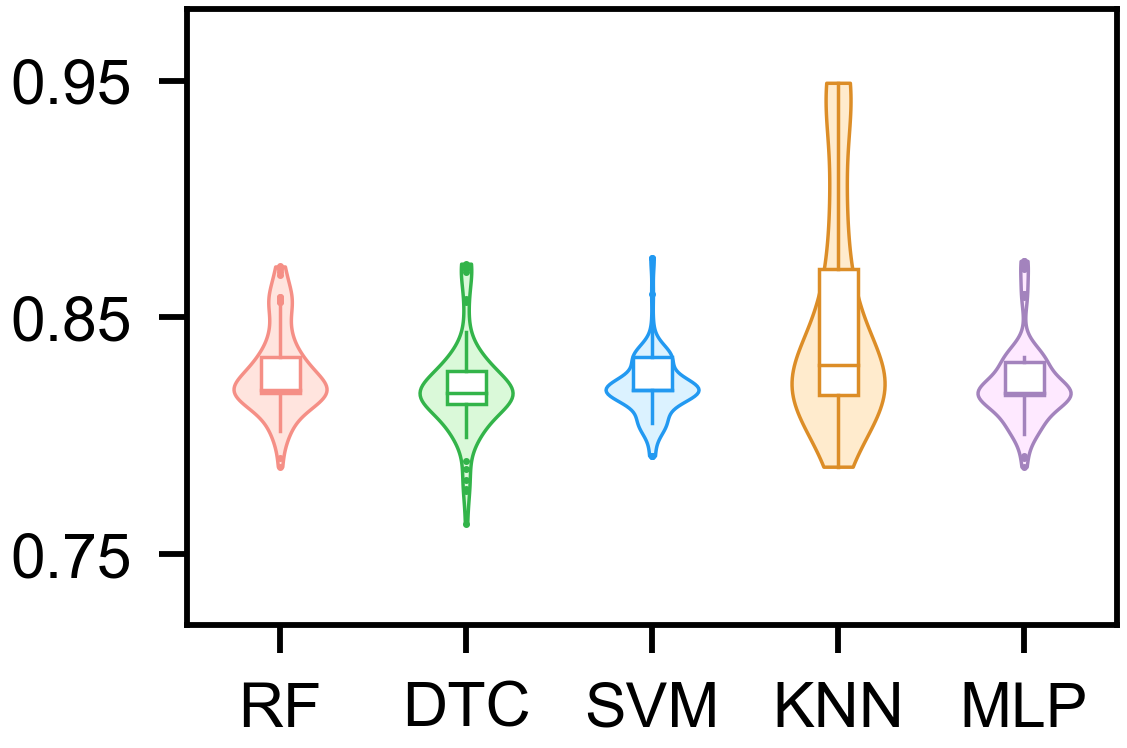

In [ ]:
# AUC violin and box plot for five classifiers

# Prepare AUC score data for each model: RF, DTC, SVM, KNN, ML
auc_data = [
    metrics_list_rf_auc,
    metrics_list_dtc_auc,
    metrics_list_svm_auc,
    metrics_list_knn_auc,
    metrics_list_mlp_auc
]

# Set font to Arial
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(12, 8))

# Draw violin plot
parts_violin = ax.violinplot(dataset=auc_data, showextrema=False)


# Define fill and edge colors for each model
colors = ['#FFE4DE', '#DAF9D9', '#DBF2FF', '#FFEBCD', '#FEE9FF']
edgecolors = ['#F58F86', '#33b44a', '#2299f1', '#dc8d27', '#a383bd']

# Set violin plot colors and styles
for pc, color, edgecolor in zip(parts_violin['bodies'], colors, edgecolors):
    pc.set_facecolor(color)
    pc.set_edgecolor(edgecolor)
    pc.set_linewidth(2.5)
    pc.set_alpha(1)

# Draw boxplot on top of violin plot for summary statistics
box = ax.boxplot(auc_data, patch_artist=True, widths=0.21, showcaps=False)
for patch, edgecolor in zip(box['boxes'], edgecolors):
    patch.set_edgecolor(edgecolor)
    patch.set_linewidth(2.5)
    patch.set_alpha(1)
    patch.set_facecolor('white')

# Set median line color
for median, color in zip(box['medians'], edgecolors):
    median.set_color(color)
    median.set_linewidth(2.5)
    median.set_alpha(1)

# Set whisker color and width
edgecolors_double = [
    '#F58F86', '#F58F86', '#33b44a', '#33b44a',
    '#2299f1', '#2299f1', '#dc8d27', '#dc8d27',
    '#a383bd', '#a383bd'
]
for whisker, color in zip(box['whiskers'], edgecolors_double):
    whisker.set_color(color)
    whisker.set_linewidth(2.5)

# Set outlier (flier) marker style and color
for flier, color in zip(box['fliers'], edgecolors):
    flier.set_marker('o')
    flier.set_markerfacecolor(color)
    flier.set_markeredgecolor(color)
    flier.set_markersize(4)

# Set x-axis tick labels for each classifier
xticklabels = ['RF', 'DTC', 'SVM', 'KNN', 'MLP']
ax.set_xticklabels(xticklabels)

# Set font size for x and y ticks
plt.xticks(fontsize=45)
plt.yticks(fontsize=45)

# Adjust axis tick width and length
plt.tick_params(axis='both', which='major', width=4.2, length=20)


# Set y-axis limits
plt.ylim(0.72, 0.98)

# Set y-axis major locator for tick intervals
plt.yticks(np.arange(0.75, 0.96, 0.1))

# Thicken all plot borders
plt.gca().spines['top'].set_linewidth(4.2)
plt.gca().spines['bottom'].set_linewidth(4.2)
plt.gca().spines['left'].set_linewidth(4.2)
plt.gca().spines['right'].set_linewidth(4.2)

# Increase distance between tick labels and axis
plt.gca().tick_params(axis='both', which='major', pad=20)
plt.show()

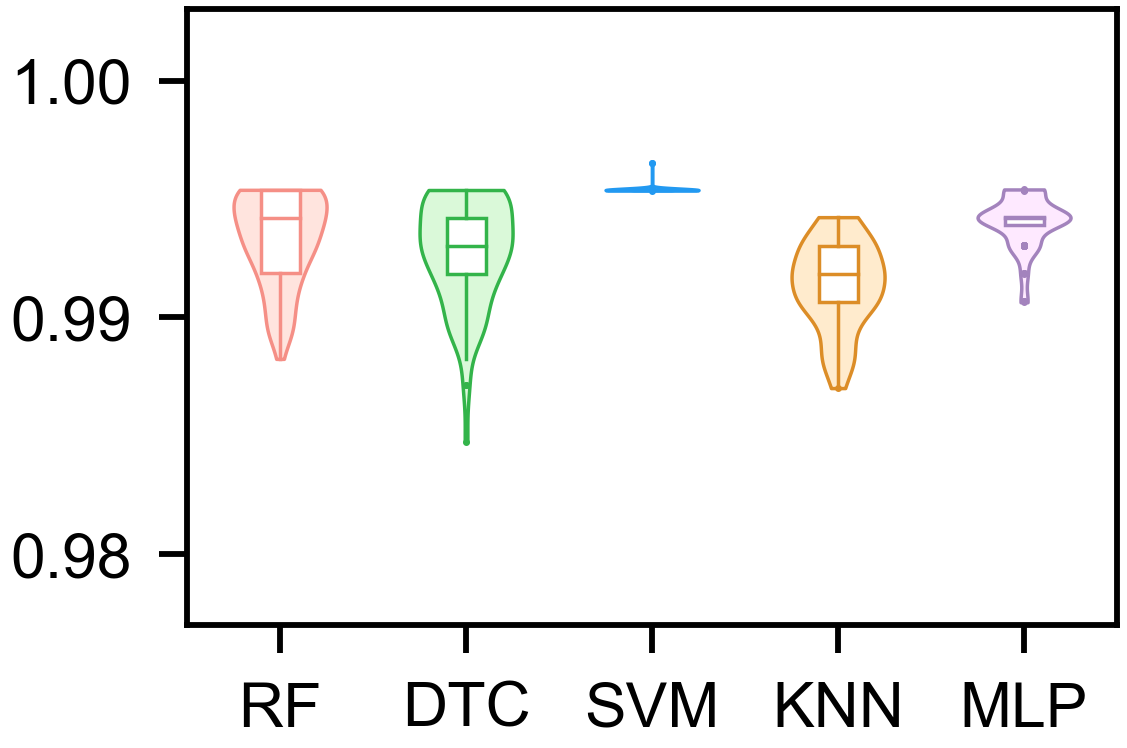

In [ ]:
# F1 violin and box plot for five classifiers

# Prepare F1 score data for each model: RF, DTC, SVM, KNN, ML
f1_data = [
    metrics_list_rf_f1,
    metrics_list_dtc_f1,
    metrics_list_svm_f1,
    metrics_list_knn_f1,
    metrics_list_mlp_f1
]

# Set font to Arial
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(12, 8))

# Draw violin plot
parts_violin = ax.violinplot(dataset=f1_data, showextrema=False)


# Define fill and edge colors for each model
colors = ['#FFE4DE', '#DAF9D9', '#DBF2FF', '#FFEBCD', '#FEE9FF']
edgecolors = ['#F58F86', '#33b44a', '#2299f1', '#dc8d27', '#a383bd']

# Set violin plot colors and styles
for pc, color, edgecolor in zip(parts_violin['bodies'], colors, edgecolors):
    pc.set_facecolor(color)
    pc.set_edgecolor(edgecolor)
    pc.set_linewidth(2.5)
    pc.set_alpha(1)

# Draw boxplot on top of violin plot for summary statistics
box = ax.boxplot(f1_data, patch_artist=True, widths=0.21, showcaps=False)
for patch, edgecolor in zip(box['boxes'], edgecolors):
    patch.set_edgecolor(edgecolor)
    patch.set_linewidth(2.5)
    patch.set_alpha(1)
    patch.set_facecolor('white')

# Set median line color
for median, color in zip(box['medians'], edgecolors):
    median.set_color(color)
    median.set_linewidth(2.5)
    median.set_alpha(1)

# Set whisker color and width
edgecolors_double = [
    '#F58F86', '#F58F86', '#33b44a', '#33b44a',
    '#2299f1', '#2299f1', '#dc8d27', '#dc8d27',
    '#a383bd', '#a383bd'
]
for whisker, color in zip(box['whiskers'], edgecolors_double):
    whisker.set_color(color)
    whisker.set_linewidth(2.5)

# Set outlier (flier) marker style and color
for flier, color in zip(box['fliers'], edgecolors):
    flier.set_marker('o')
    flier.set_markerfacecolor(color)
    flier.set_markeredgecolor(color)
    flier.set_markersize(4)

# Set x-axis tick labels for each classifier
xticklabels = ['RF', 'DTC', 'SVM', 'KNN', 'MLP']
ax.set_xticklabels(xticklabels)

# Set font size for x and y ticks
plt.xticks(fontsize=45)
plt.yticks(fontsize=45)

# Adjust axis tick width and length
plt.tick_params(axis='both', which='major', width=4.2, length=20)

# Set y-axis limits
plt.ylim(0.977, 1.003)

# Set y-axis major locator for tick intervals
plt.yticks(np.arange(0.98, 1.0, 0.01))

# Thicken all plot borders
plt.gca().spines['top'].set_linewidth(4.2)
plt.gca().spines['bottom'].set_linewidth(4.2)
plt.gca().spines['left'].set_linewidth(4.2)
plt.gca().spines['right'].set_linewidth(4.2)

# Increase distance between tick labels and axis
plt.gca().tick_params(axis='both', which='major', pad=20)
plt.show()

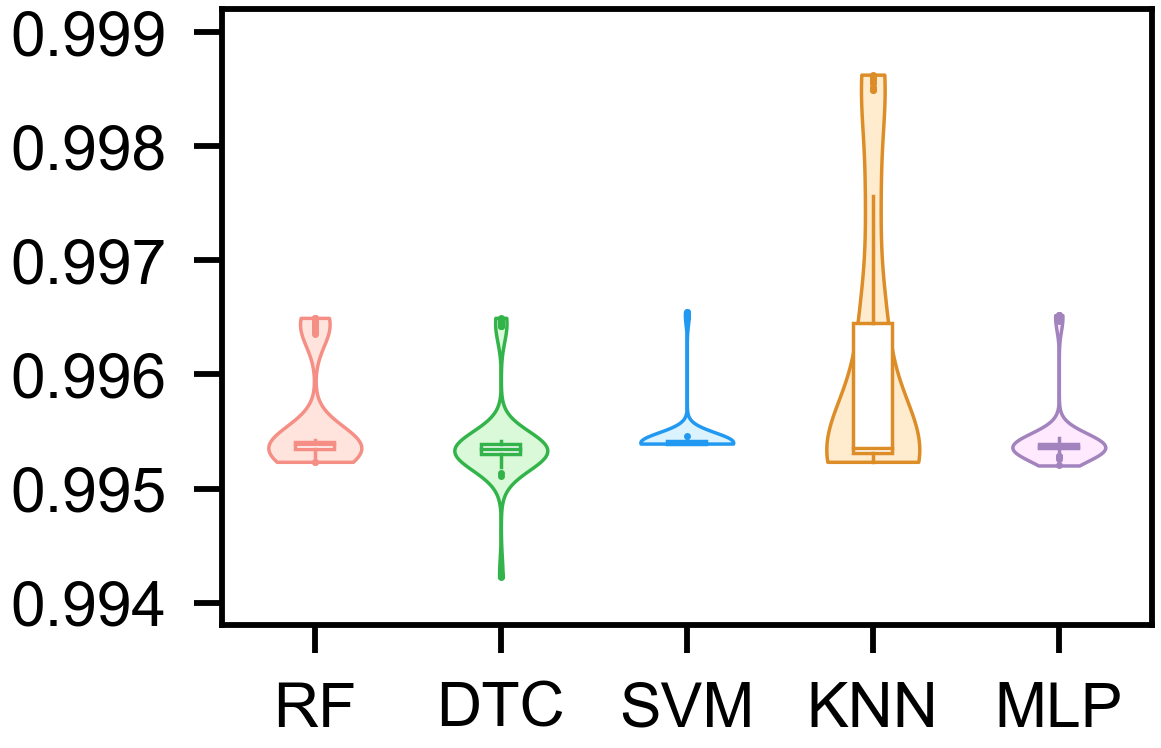

In [ ]:
# AUPRC violin and box plot for five classifiers

# Prepare AUPRC score data for each model: RF, DTC, SVM, KNN, ML
auprc_data = [
    metrics_list_rf_auprc,
    metrics_list_dtc_auprc,
    metrics_list_svm_auprc,
    metrics_list_knn_auprc,
    metrics_list_mlp_auprc
]

# Set font to Arial
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(12, 8))

# Draw violin plot
parts_violin = ax.violinplot(dataset=auprc_data, showextrema=False)


# Define fill and edge colors for each model
colors = ['#FFE4DE', '#DAF9D9', '#DBF2FF', '#FFEBCD', '#FEE9FF']
edgecolors = ['#F58F86', '#33b44a', '#2299f1', '#dc8d27', '#a383bd']

# Set violin plot colors and styles
for pc, color, edgecolor in zip(parts_violin['bodies'], colors, edgecolors):
    pc.set_facecolor(color)
    pc.set_edgecolor(edgecolor)
    pc.set_linewidth(2.5)
    pc.set_alpha(1)

# Draw boxplot on top of violin plot for summary statistics
box = ax.boxplot(auprc_data, patch_artist=True, widths=0.21, showcaps=False)
for patch, edgecolor in zip(box['boxes'], edgecolors):
    patch.set_edgecolor(edgecolor)
    patch.set_linewidth(2.5)
    patch.set_alpha(1)
    patch.set_facecolor('white')

# Set median line color
for median, color in zip(box['medians'], edgecolors):
    median.set_color(color)
    median.set_linewidth(2.5)
    median.set_alpha(1)

# Set whisker color and width
edgecolors_double = [
    '#F58F86', '#F58F86', '#33b44a', '#33b44a',
    '#2299f1', '#2299f1', '#dc8d27', '#dc8d27',
    '#a383bd', '#a383bd'
]
for whisker, color in zip(box['whiskers'], edgecolors_double):
    whisker.set_color(color)
    whisker.set_linewidth(2.5)

# Set outlier (flier) marker style and color
for flier, color in zip(box['fliers'], edgecolors):
    flier.set_marker('o')
    flier.set_markerfacecolor(color)
    flier.set_markeredgecolor(color)
    flier.set_markersize(4)

# Set x-axis tick labels for each classifier
xticklabels = ['RF', 'DTC', 'SVM', 'KNN', 'MLP']
ax.set_xticklabels(xticklabels)

# Set font size for x and y ticks
plt.xticks(fontsize=45)
plt.yticks(fontsize=45)

# Adjust axis tick width and length
plt.tick_params(axis='both', which='major', width=4.2, length=20)

# Set y-axis limits
plt.ylim(0.9938, 0.9992)

# Thicken all plot borders
plt.gca().spines['top'].set_linewidth(4.2)
plt.gca().spines['bottom'].set_linewidth(4.2)
plt.gca().spines['left'].set_linewidth(4.2)
plt.gca().spines['right'].set_linewidth(4.2)

# Increase distance between tick labels and axis
plt.gca().tick_params(axis='both', which='major', pad=20)
plt.show()

In [30]:
# Combine SVM models and their MCC scores into a list of tuples
combined = list(zip(models_svm, metrics_list_svm_mcc))

# Sort the combined list by MCC score in descending order
sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)

# Select the top 10% models with the highest MCC scores
top_10_models = sorted_combined[:10]

# Extract the parameter sets of the top 10% SVM models
models_svm_10 = [model[0] for model in top_10_models]

# Print the parameter sets of the top 10% SVM models
for params in models_svm_10:
    print(params)

{'clf__C': 0.005, 'clf__degree': 0, 'clf__kernel': 'rbf'}
{'clf__C': 0.005, 'clf__degree': 0, 'clf__kernel': 'rbf'}
{'clf__C': 0.005, 'clf__degree': 10, 'clf__kernel': 'poly'}
{'clf__C': 0.005, 'clf__degree': 0, 'clf__kernel': 'rbf'}
{'clf__C': 0.005, 'clf__degree': 1, 'clf__kernel': 'poly'}
{'clf__C': 0.005, 'clf__degree': 1, 'clf__kernel': 'poly'}
{'clf__C': 0.005, 'clf__degree': 1, 'clf__kernel': 'poly'}
{'clf__C': 0.005, 'clf__degree': 1, 'clf__kernel': 'poly'}
{'clf__C': 0.005, 'clf__degree': 1, 'clf__kernel': 'poly'}
{'clf__C': 0.005, 'clf__degree': 1, 'clf__kernel': 'poly'}


In [31]:
# Perform oversampling using SVMSMOTE to address class imbalance
svmsmote = SVMSMOTE(random_state=1, k_neighbors=2)
X_train_resampled, Y_train_resampled = svmsmote.fit_resample(X_train, Y_train)

# Train SVM models using the top 10% best hyperparameter combinations
best_model_svm_1 = SVC(class_weight='balanced', C=0.005, degree=0, kernel='rbf', probability=True, random_state=1)
best_model_svm_2 = SVC(class_weight='balanced', C=0.005, degree=10, kernel='poly', probability=True, random_state=1)
best_model_svm_3 = SVC(class_weight='balanced', C=0.005, degree=1, kernel='poly', probability=True, random_state=1)

# Fit the models on the resampled training data
best_model_svm_1.fit(X_train_resampled, Y_train_resampled)
best_model_svm_2.fit(X_train_resampled, Y_train_resampled)
best_model_svm_3.fit(X_train_resampled, Y_train_resampled)

# Get the decision function values for each model on the test set
svm_probs1 = best_model_svm_1.decision_function(X_test)
svm_probs2 = best_model_svm_2.decision_function(X_test)
svm_probs3 = best_model_svm_3.decision_function(X_test)

# Stack the decision function scores for all models
stacked_probs = np.vstack([ svm_probs1, svm_probs2, svm_probs3])

# Calculate the mean probability across all models
mean_probs = np.mean(stacked_probs, axis=0)

# Combine mean_probs and Y_test into a DataFrame
result_mean_df = pd.DataFrame({'result_mean': mean_probs, 'True_label': Y_test})

# Map True_label: 0 to 'Non-Zoonotic', 1 to 'Zoonotic'
result_mean_df['True_label'] = result_mean_df['True_label'].map({0: 'Non-Zoonotic', 1: 'Zoonotic'})

# Split result_mean_df into two DataFrames based on True_label
result_mean_nonzoonotic = result_mean_df[result_mean_df['True_label'] == 'Non-Zoonotic']
result_mean_zoonotic = result_mean_df[result_mean_df['True_label'] == 'Zoonotic']


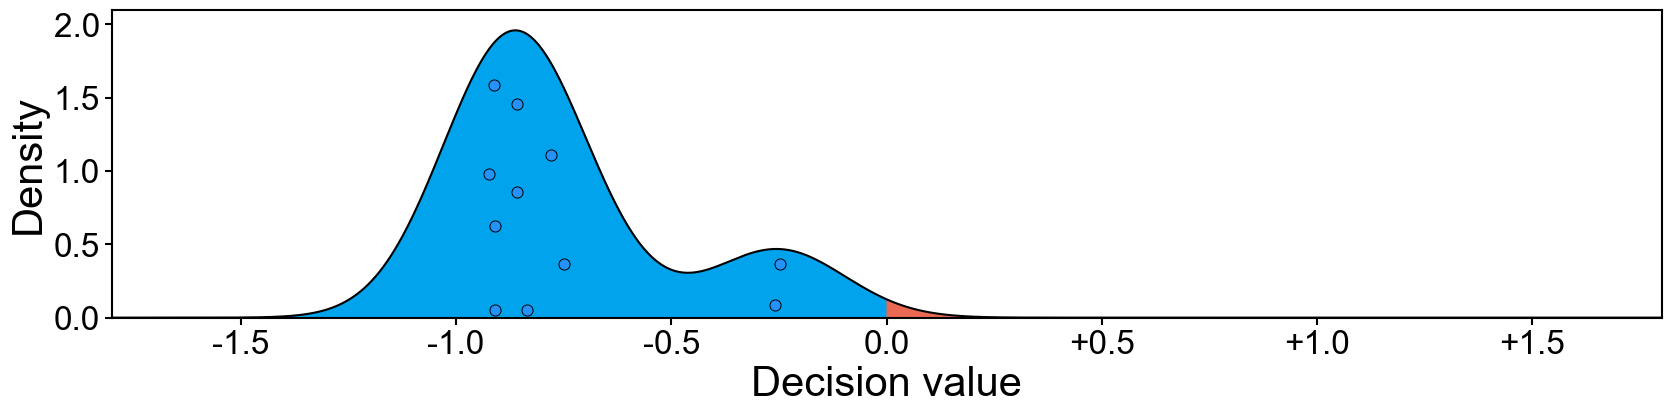

In [122]:
# Set font to Arial
plt.rcParams['font.family'] = 'Arial'

# Create a new figure and axis with specified size
fig, ax = plt.subplots(figsize=(20, 4))

# Calculate kernel density estimation for non-zoonotic samples
kde_nonzoonotic = gaussian_kde(result_mean_nonzoonotic['result_mean'])

# Generate a range of x values for plotting the density curve
x = np.linspace(-1.8, 1.8, 10000)

# Compute the density values for the x range
y_nonzoonotic = kde_nonzoonotic(x)

# Plot the kernel density estimation curve
ax.plot(x, y_nonzoonotic, color='black')

# Set the y-axis limits
ax.set_ylim(0, 2.1)

# Fill the area under the curve for negative values (blue) and positive values (red)
plt.fill_between(x, y_nonzoonotic, where=x<0, color='#00A3EC')
plt.fill_between(x, y_nonzoonotic, where=x>0, color='#E96953')


# Prepare scatter points for each sample
dot_x = result_mean_nonzoonotic['result_mean'].values
dot_y = []

# Distribute scatter points along the y-axis within the density curve
for i, x in enumerate(dot_x):
    dot_y.append(np.linspace(0.15, kde_nonzoonotic(x), num=10)[i % 10]) 
dot_y = [y - 0.1 for y in dot_y]

# Plot scatter points on the density curve
ax.plot(dot_x, dot_y, color='black', marker='o', linestyle='', markersize=8, 
        markerfacecolor = '#2591fa', alpha = 1, markeredgewidth = 0.7)

# Set font size for x and y axis tick labels
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Adjust axis tick width and length
plt.tick_params(axis='both', which='major', width=1.5, length=5)

# Set border thickness for all sides of the plot
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(1.5)

# Set x-axis limits and ticks
ax.set_xlim(-1.8, 1.8)
ax.set_xticks([-1.5, -1.0, -0.5, 0, 0.5, 1, 1.5])

# Custom tick formatter: add '+' sign for positive values
def format_func(x, pos):
    return f'+{x:.1f}' if x > 0 else f'{x:.1f}'

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

# Set y-axis ticks
ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])

# Set axis labels
ax.set_xlabel('Decision value', fontsize=30)
ax.set_ylabel('Density', fontsize=30)
plt.show()

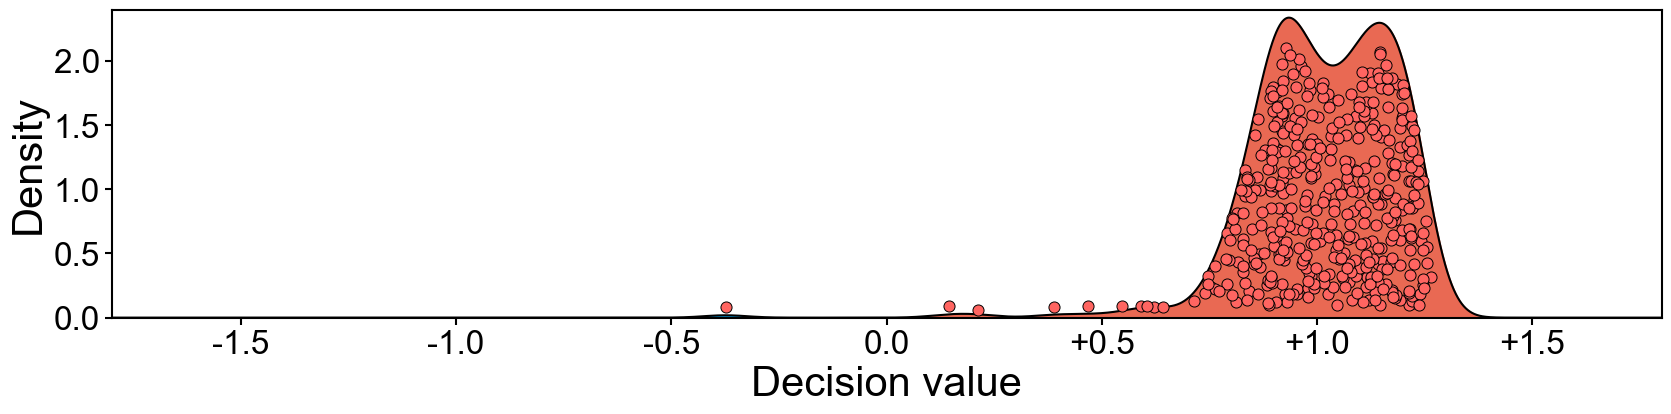

In [123]:
# Set font to Arial
plt.rcParams['font.family'] = 'Arial'

# Create a new figure and axis with specified size
fig, ax = plt.subplots(figsize=(20, 4))

# Calculate kernel density estimation for zoonotic samples
kde_zoonotic = gaussian_kde(result_mean_zoonotic['result_mean'])

# Generate a range of x values for plotting the density curve
x = np.linspace(-1.8, 1.8, 10000)

# Compute the density values for the x range
y_zoonotic = kde_zoonotic(x)

# Plot the kernel density estimation curve
ax.plot(x, y_zoonotic, color='black')

# Set the y-axis limits
ax.set_ylim(0, 2.4)

# Fill the area under the curve for negative values (blue) and positive values (red)
plt.fill_between(x, y_zoonotic, where=x<0, color='#00A3EC')
plt.fill_between(x, y_zoonotic, where=x>0, color='#E96953')


# Prepare scatter points for each sample
dot_x = result_mean_zoonotic['result_mean'].values
dot_y = []

# Distribute scatter points along the y-axis within the density curve
for i, x in enumerate(dot_x):
    y_max = kde_zoonotic(x) * 0.91
    y_vals = np.linspace(0.1, y_max, num=100)
    dot_y.append(y_vals[i % 100])

# Plot scatter points on the density curve
ax.plot(dot_x, dot_y, color='black', marker='o', linestyle='', markersize=8, 
        markerfacecolor = '#ff6561', alpha = 1, markeredgewidth = 0.7)

# Set font size for x and y axis tick labels
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Adjust axis tick width and length
plt.tick_params(axis='both', which='major', width=1.5, length=5)

# Set border thickness for all sides of the plot
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(1.5)

# Set x-axis limits and ticks
ax.set_xlim(-1.8, 1.8)
ax.set_xticks([-1.5, -1.0, -0.5, 0, 0.5, 1, 1.5])

# Custom tick formatter: add '+' sign for positive values
def format_func(x, pos):
    return f'+{x:.1f}' if x > 0 else f'{x:.1f}'

ax.xaxis.set_major_formatter(FuncFormatter(format_func))

# Set y-axis ticks
ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])

# Set axis labels
ax.set_xlabel('Decision value', fontsize=30)
ax.set_ylabel('Density', fontsize=30)
plt.show()

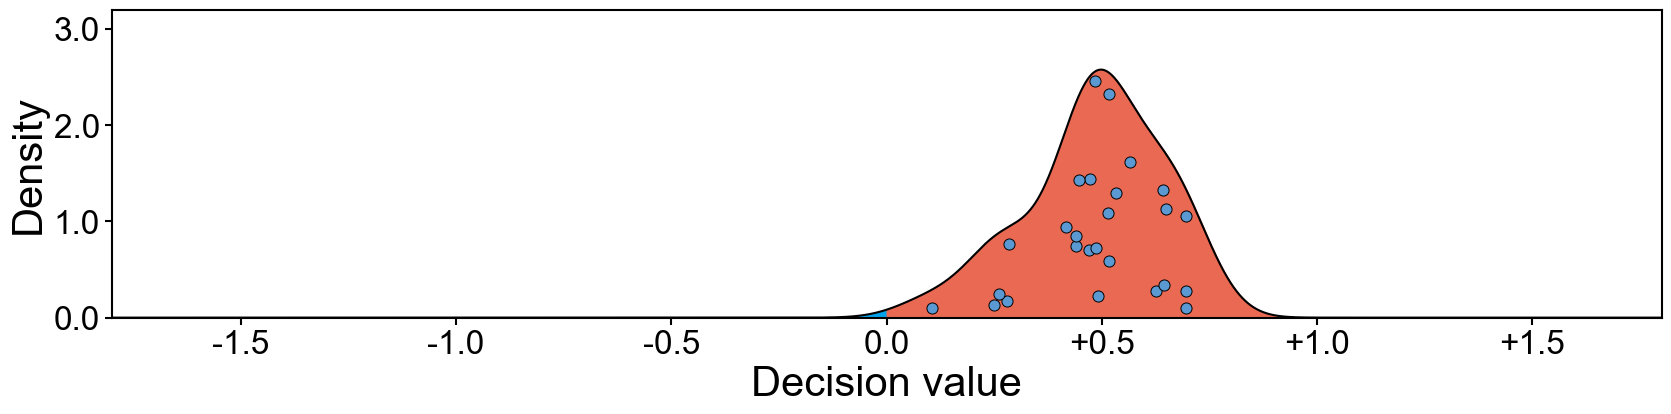

In [124]:
# Extract rows from subset_zoonotic_predict based on the given Brucella canis IDs
Brucella_canisID = [
    "GCA_000018525.1_ASM1852v1_genomic", "GCA_000238195.1_ASM23819v1_genomic",
    "GCA_000366825.1_Bruc_cani_UK10_02_V1_genomic", "GCA_000367265.1_Bruc_cani_CNGB_1172_V1_genomic",
    "GCA_000367285.1_Bruc_cani_CNGB_1324_V1_genomic", "GCA_000367305.1_Bruc_cani_F7_05A_V1_genomic",
    "GCA_000370585.1_Bruc_cani_79_122_V1_genomic", "GCA_000370605.1_Bruc_cani_CNGB_513_V1_genomic",
    "GCA_000480275.1_Bruc_cani_96-7258_V1_genomic", "GCA_000480295.1_Bruc_cani_04-2330-1_V1_genomic",
    "GCA_000530495.1_Oliveri_genomic", "GCA_000691585.1_ASM69158v1_genomic",
    "GCA_000740335.1_ASM74033v1_genomic", "GCA_001078335.1_B.canis_SCL_genomic",
    "GCA_001715365.1_ASM171536v1_genomic", "GCA_001715405.1_ASM171540v1_genomic",
    "GCA_001715445.1_ASM171544v1_genomic", "GCA_001758265.1_ASM175826v1_genomic",
    "GCA_002591255.1_ASM259125v1_genomic", "GCA_003010715.1_ASM301071v1_genomic",
    "GCA_004127195.1_ASM412719v1_genomic", "GCA_900491895.1_07-2859-6071_genomic",
    "GCA_900491905.1_96-9626_genomic", "GCA_900491915.1_07-2859-6070_genomic",
    "GCA_900491925.1_10469_genomic", "GCA_900497665.1_09-369-776-1_genomic"
]

# Filter the DataFrame for the specified Brucella canis IDs
subset_brucella_canis = subset_zoonotic_predict[subset_zoonotic_predict['ID'].isin(Brucella_canisID)]

# Prepare feature matrix by dropping 'zoonotic' and 'ID' columns
X_brucella_canis = subset_brucella_canis.drop(['zoonotic', 'ID'], axis=1)

# Get decision function values from three best SVM models
svm_probs1_brucella_canis = best_model_svm_1.decision_function(X_brucella_canis)
svm_probs2_brucella_canis = best_model_svm_2.decision_function(X_brucella_canis)
svm_probs3_brucella_canis = best_model_svm_3.decision_function(X_brucella_canis)

# Stack the decision function scores and calculate the mean probability
stacked_probs_brucella_canis = np.vstack([svm_probs1_brucella_canis, svm_probs2_brucella_canis, svm_probs3_brucella_canis])
mean_probs_brucella_canis = np.mean(stacked_probs_brucella_canis, axis=0)

# Plot kernel density estimation and scatter points for Brucella canis samples
fig, ax = plt.subplots(figsize=(20, 4))

# Calculate kernel density estimation
kde_brucella_canis = gaussian_kde(mean_probs_brucella_canis)
x = np.linspace(-1.8, 1.8, 10000)
y_brucella_canis = kde_brucella_canis(x)

# Plot KDE curve
ax.plot(x, y_brucella_canis, color='black')
ax.set_ylim(0, 3.2)

# Fill negative and positive regions with different colors
plt.fill_between(x, y_brucella_canis, where=x < 0, color='#00A3EC')
plt.fill_between(x, y_brucella_canis, where=x > 0, color='#E96953')

# Prepare scatter points distributed along the KDE curve
dot_x = mean_probs_brucella_canis
dot_y = []
for i, val in enumerate(dot_x):
    dot_y.append(np.linspace(0.2, kde_brucella_canis(val), num=20)[i % 20])
dot_y = [y - 0.1 for y in dot_y]

# Plot scatter points
ax.plot(dot_x, dot_y, color='black', marker='o', linestyle='', markersize=8,
        markerfacecolor='#5b99d2', alpha=1, markeredgewidth=0.7)

# Set axis ticks
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tick_params(axis='both', which='major', width=1.5, length=5)

# Set border thickness
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(1.5)

ax.set_xlim(-1.8, 1.8)
ax.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])

# Custom tick formatter: add '+' for positive values
def format_func(x, pos):
    return f'+{x:.1f}' if x > 0 else f'{x:.1f}'

ax.xaxis.set_major_formatter(FuncFormatter(format_func))
ax.set_yticks([0.0, 1.0, 2.0, 3.0])
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))

ax.set_xlabel('Decision value', fontsize=30)
ax.set_ylabel('Density', fontsize=30)
plt.show()

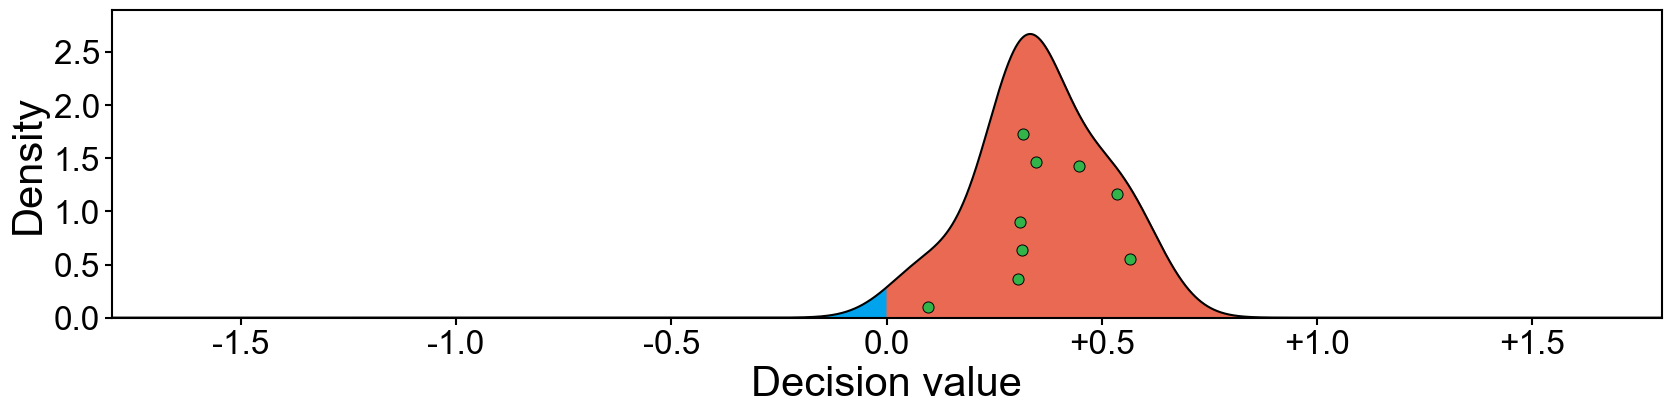

In [125]:
# Extract rows from subset_zoonotic_predict based on the given Brucella ceti IDs
Brucella_cetiID=[
    "GCA_000157835.1_ASM15783v1_genomic","GCA_000157855.1_ASM15785v1_genomic", 
    "GCA_000158755.1_ASM15875v1_genomic","GCA_000158775.1_ASM15877v1_genomic", 
    "GCA_000182425.1_ASM18242v1_genomic","GCA_000590795.1_ASM59079v1_genomic", 
    "GCA_000590815.1_ASM59081v1_genomic","GCA_002245555.1_ASM224555v1_genomic", 
    "GCA_014193785.1_ASM1419378v1_genomic" 
]

# Filter the DataFrame for the specified Brucella ceti IDs
subset_brucella_ceti = subset_zoonotic_predict[subset_zoonotic_predict['ID'].isin(Brucella_cetiID)]

# Prepare feature matrix by dropping 'zoonotic' and 'ID' columns
X_brucella_ceti = subset_brucella_ceti.drop(['zoonotic','ID'],axis = 1)

# Get decision function values from three best SVM models
svm_probs1_brucella_ceti = best_model_svm_1.decision_function(X_brucella_ceti)
svm_probs2_brucella_ceti = best_model_svm_2.decision_function(X_brucella_ceti)
svm_probs3_brucella_ceti = best_model_svm_3.decision_function(X_brucella_ceti)

# Stack the decision function scores for all models
stacked_probs_brucella_ceti = np.vstack([svm_probs1_brucella_ceti, svm_probs2_brucella_ceti, svm_probs3_brucella_ceti])

# Calculate the mean probability across all models
mean_probs_brucella_ceti = np.mean(stacked_probs_brucella_ceti, axis=0)

# Plot kernel density estimation and scatter points for Brucella ceti samples
fig, ax = plt.subplots(figsize=(20, 4))

# Calculate kernel density estimation
kde_brucella_ceti = gaussian_kde(mean_probs_brucella_ceti)
x = np.linspace(-1.8, 1.8, 10000)
y_brucella_ceti = kde_brucella_ceti(x)

# Plot KDE curve
ax.plot(x, y_brucella_ceti, color='black')
ax.set_ylim(0, 2.9)

# Fill negative and positive regions with different colors
plt.fill_between(x, y_brucella_ceti, where=x<0, color='#00A3EC')
plt.fill_between(x, y_brucella_ceti, where=x>0, color='#E96953')

# Prepare scatter points distributed along the KDE curve
dot_x = mean_probs_brucella_ceti
dot_y = []
for i, x in enumerate(dot_x):
    dot_y.append(np.linspace(0.2, kde_brucella_ceti(x), num=10)[i % 10]) 
dot_y = [y - 0.1 for y in dot_y]

# Plot scatter points
ax.plot(dot_x, dot_y, color='black', marker='o', linestyle='', markersize=8, 
        markerfacecolor = '#33b44a', alpha = 1, markeredgewidth = 0.7)

# Set axis ticks
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tick_params(axis='both', which='major', width=1.5, length=5)

# Set border thickness
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(1.5)

ax.set_xlim(-1.8, 1.8)
ax.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])

# Custom tick formatter: add '+' for positive values
def format_func(x, pos):
    return f'+{x:.1f}' if x > 0 else f'{x:.1f}'
ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xlabel('Decision value', fontsize=30)
ax.set_ylabel('Density', fontsize=30)
plt.show()

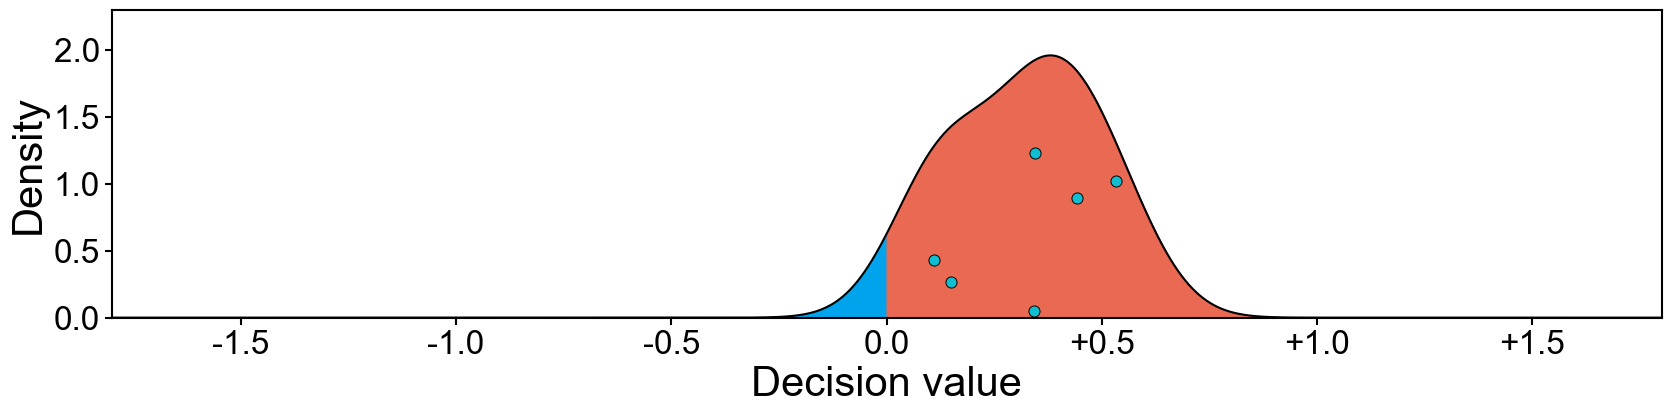

In [126]:
# Extract rows from subset_zoonotic_predict based on the given Brucella pinnipedialis IDs
Brucella_pinnipedialisID=[
    "GCA_000157795.1_ASM15779v1_genomic", "GCA_000157815.1_ASM15781v1_genomic",
    "GCA_000158675.1_ASM15867v1_genomic", "GCA_000221005.1_ASM22100v1_genomic",
    "GCA_000740275.1_ASM74027v1_genomic","GCA_015624465.1_ASM1562446v1_genomic"
]

# Filter the DataFrame for the specified Brucella pinnipedialis IDs
subset_brucella_pinnipedialis = subset_zoonotic_predict[subset_zoonotic_predict['ID'].isin(Brucella_pinnipedialisID)]

# Prepare feature matrix by dropping 'zoonotic' and 'ID' columns
X_brucella_pinnipedialis = subset_brucella_pinnipedialis.drop(['zoonotic','ID'],axis = 1)

# Get decision function values from three best SVM models
svm_probs1_brucella_pinnipedialis = best_model_svm_1.decision_function(X_brucella_pinnipedialis)
svm_probs2_brucella_pinnipedialis = best_model_svm_2.decision_function(X_brucella_pinnipedialis)
svm_probs3_brucella_pinnipedialis = best_model_svm_3.decision_function(X_brucella_pinnipedialis)

# Stack the decision function scores for all models
stacked_probs_brucella_pinnipedialis = np.vstack([svm_probs1_brucella_pinnipedialis, svm_probs2_brucella_pinnipedialis, svm_probs3_brucella_pinnipedialis])

# Calculate the mean probability across all models
mean_probs_brucella_pinnipedialis = np.mean(stacked_probs_brucella_pinnipedialis, axis=0)

# Plot kernel density estimation and scatter points for Brucella pinnipedialis samples
fig, ax = plt.subplots(figsize=(20, 4))


# Calculate kernel density estimation
kde_brucella_pinnipedialis = gaussian_kde(mean_probs_brucella_pinnipedialis)
x = np.linspace(-1.8, 1.8, 10000)
y_brucella_pinnipedialis = kde_brucella_pinnipedialis(x)

# Plot KDE curve
ax.plot(x, y_brucella_pinnipedialis, color='black')
ax.set_ylim(0, 2.3)
ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])

# Fill negative and positive regions with different colors
plt.fill_between(x, y_brucella_pinnipedialis, where=x<0, color='#00A3EC') 
plt.fill_between(x, y_brucella_pinnipedialis, where=x>0, color='#E96953')

# Prepare scatter points distributed along the KDE curve
dot_x = mean_probs_brucella_pinnipedialis
dot_y = []
for i, x in enumerate(dot_x):
    dot_y.append(np.linspace(0.15, kde_brucella_pinnipedialis(x), num=7)[i % 7]) 

# Plot scatter points
dot_y = [y - 0.1 for y in dot_y]
ax.plot(dot_x, dot_y, color='black', marker='o', linestyle='', markersize=8, 
        markerfacecolor = '#10bed2', alpha = 1, markeredgewidth = 0.7)

# Set axis ticks
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tick_params(axis='both', which='major', width=1.5, length=5)

# Set border thickness
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(1.5)

ax.set_xlim(-1.8, 1.8)
ax.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])

# Custom tick formatter: add '+' for positive values
def format_func(x, pos):
    return f'+{x:.1f}' if x > 0 else f'{x:.1f}'
ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xlabel('Decision value', fontsize=30)
ax.set_ylabel('Density', fontsize=30)
plt.show()

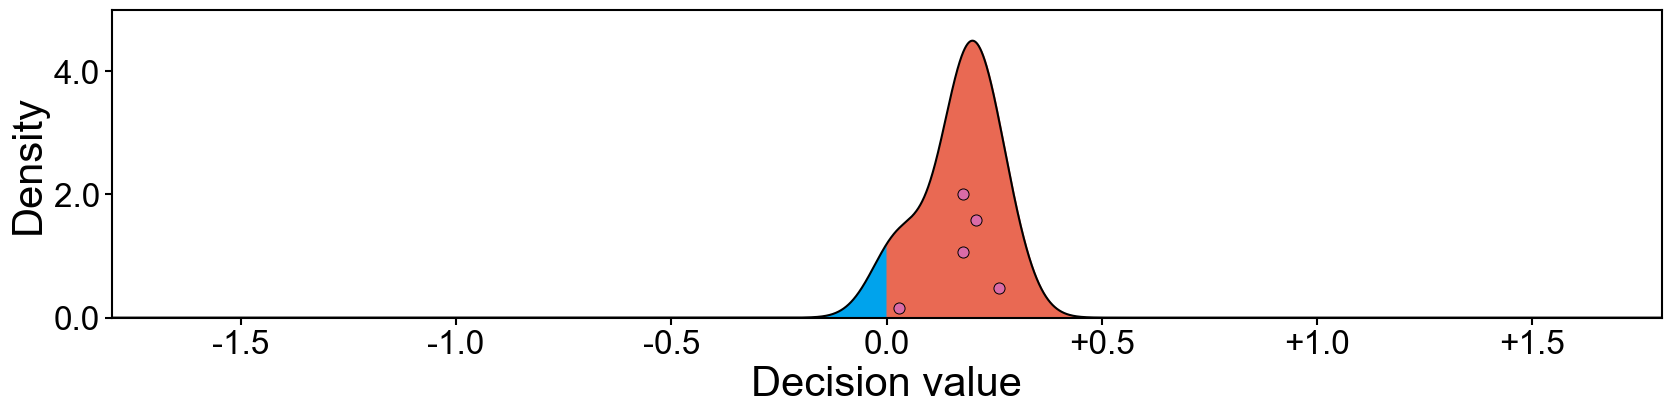

In [127]:
# Extract rows from subset_zoonotic_predict based on the given Brucella neotomae IDs
Brucella_neotomaeID=[
    "GCA_000158715.1_ASM15871v1_genomic","GCA_000742255.1_ASM74225v1_genomic",
    "GCA_900446105.1_59302_A02_genomic","GCA_900446115.1_59302_H01_genomic",
    "GCA_900446125.1_57572_C01_genomic"
]

# Filter the DataFrame for the specified Brucella neotomae IDs
subset_brucella_neotomae = subset_zoonotic_predict[subset_zoonotic_predict['ID'].isin(Brucella_neotomaeID)]

# Prepare feature matrix by dropping 'zoonotic' and 'ID' columns
X_brucella_neotomae = subset_brucella_neotomae.drop(['zoonotic','ID'],axis = 1)

# Get decision function values from three best SVM models
svm_probs1_brucella_neotomae = best_model_svm_1.decision_function(X_brucella_neotomae)
svm_probs2_brucella_neotomae = best_model_svm_2.decision_function(X_brucella_neotomae)
svm_probs3_brucella_neotomae = best_model_svm_3.decision_function(X_brucella_neotomae)

# Stack the decision function scores for all models
stacked_probs_brucella_neotomae = np.vstack([svm_probs1_brucella_neotomae, svm_probs2_brucella_neotomae, svm_probs3_brucella_neotomae])

# Calculate the mean probability across all models
mean_probs_brucella_neotomae = np.mean(stacked_probs_brucella_neotomae, axis=0)

# Plot kernel density estimation and scatter points for Brucella neotomae samples
fig, ax = plt.subplots(figsize=(20, 4))
 
# Calculate kernel density estimation
kde_brucella_neotomae = gaussian_kde(mean_probs_brucella_neotomae)
x = np.linspace(-1.8, 1.8, 10000)
y_brucella_neotomae = kde_brucella_neotomae(x)

# Plot KDE curve
ax.plot(x, y_brucella_neotomae, color='black')
ax.set_ylim(0, 5)
ax.set_yticks([0.0, 2.0, 4.0])

# Fill negative and positive regions with different colors
plt.fill_between(x, y_brucella_neotomae, where=x<0, color='#00A3EC')
plt.fill_between(x, y_brucella_neotomae, where=x>0, color='#E96953')

# Prepare scatter points distributed along the KDE curve
dot_x = mean_probs_brucella_neotomae
dot_y = []
for i, x in enumerate(dot_x):
    dot_y.append(np.linspace(0.15, kde_brucella_neotomae(x), num=10)[i % 10]) 


# Plot scatter points
ax.plot(dot_x, dot_y, color='black', marker='o', linestyle='', markersize=8, 
        markerfacecolor = '#da6ba7', alpha = 1, markeredgewidth = 0.7)

# Set axis ticks
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tick_params(axis='both', which='major', width=1.5, length=5)

# Set border thickness
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(1.5)

ax.set_xlim(-1.8, 1.8)
ax.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])

# Custom tick formatter: add '+' for positive values
def format_func(x, pos):
    return f'+{x:.1f}' if x > 0 else f'{x:.1f}'
ax.xaxis.set_major_formatter(FuncFormatter(format_func))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))

ax.set_xlabel('Decision value', fontsize=30)
ax.set_ylabel('Density', fontsize=30) 
plt.show()

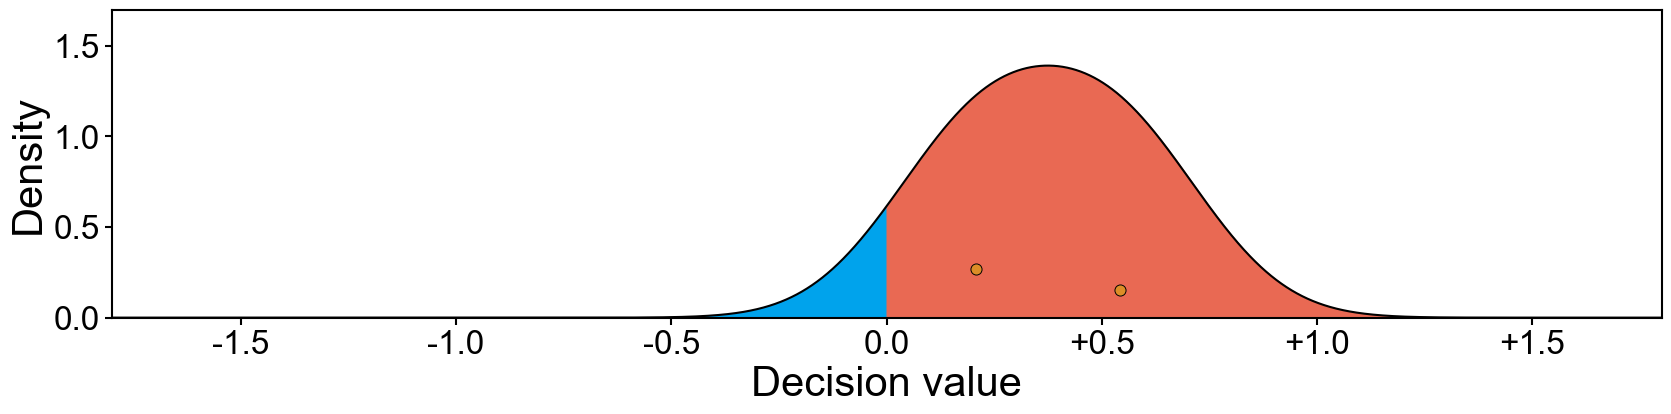

In [128]:
# Extract rows from subset_zoonotic_predict based on the given Brucella microti IDs
Brucella_microtiID=["GCA_000022745.1_ASM2274v1_genomic","GCA_902807045.1_17-2122-4144_genomic"]

# Filter the DataFrame for the specified Brucella microti IDs
subset_brucella_microti = subset_zoonotic_predict[subset_zoonotic_predict['ID'].isin(Brucella_microtiID)]

# Prepare feature matrix by dropping 'zoonotic' and 'ID' columns
X_brucella_microti = subset_brucella_microti.drop(['zoonotic','ID'],axis = 1)

# Get decision function values from three best SVM models
svm_probs1_brucella_microti = best_model_svm_1.decision_function(X_brucella_microti)
svm_probs2_brucella_microti = best_model_svm_2.decision_function(X_brucella_microti)
svm_probs3_brucella_microti = best_model_svm_3.decision_function(X_brucella_microti)

# Stack the decision function scores for all models
stacked_probs_brucella_microti = np.vstack([svm_probs1_brucella_microti, svm_probs2_brucella_microti, svm_probs3_brucella_microti])

# Calculate the mean probability across all models
mean_probs_brucella_microti = np.mean(stacked_probs_brucella_microti, axis=0)

# Plot kernel density estimation and scatter points for Brucella microti samples
fig, ax = plt.subplots(figsize=(20, 4))

# Calculate kernel density estimation
kde_brucella_microti = gaussian_kde(mean_probs_brucella_microti)
x = np.linspace(-1.8, 1.8, 10000)
y_brucella_microti = kde_brucella_microti(x)

# Plot KDE curve
ax.plot(x, y_brucella_microti, color='black')
ax.set_ylim(0, 1.7)
ax.set_yticks([0.0, 0.5, 1.0, 1.5])

# Fill negative and positive regions with different colors
plt.fill_between(x, y_brucella_microti, where=x<0, color='#00A3EC')
plt.fill_between(x, y_brucella_microti, where=x>0, color='#E96953')

# Prepare scatter points distributed along the KDE curve
dot_x = mean_probs_brucella_microti
dot_y = []
for i, x in enumerate(dot_x):
    dot_y.append(np.linspace(0.15, kde_brucella_microti(x), num=10)[i % 10]) 

# Plot scatter points
ax.plot(dot_x, dot_y, color='black', marker='o', linestyle='', markersize=8, 
        markerfacecolor = '#dc8d27', alpha = 1, markeredgewidth = 0.7)

# Set axis ticks
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tick_params(axis='both', which='major', width=1.5, length=5)

# Set border thickness
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(1.5)

ax.set_xlim(-1.8, 1.8)
ax.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


# Custom tick formatter: add '+' for positive values
def format_func(x, pos):
    return f'+{x:.1f}' if x > 0 else f'{x:.1f}'
ax.xaxis.set_major_formatter(FuncFormatter(format_func))


ax.set_xlabel('Decision value', fontsize=30)
ax.set_ylabel('Density', fontsize=30)
plt.show()

In [39]:
# Extract rows from subset_zoonotic_predict based on the given Brucella vulpis IDs
Brucella_vulpisID=["GCA_001511795.1_BVF965_genomic","GCA_900000005.1_BVF60_genomic"]

# Filter the DataFrame for the specified Brucella vulpis IDs
subset_brucella_vulpis = subset_zoonotic_predict[subset_zoonotic_predict['ID'].isin(Brucella_vulpisID)]

# Prepare feature matrix by dropping 'zoonotic' and 'ID' columns
X_brucella_vulpis = subset_brucella_vulpis.drop(['zoonotic','ID'],axis = 1)

# Get decision function values from three best SVM models
svm_probs1_brucella_vulpis = best_model_svm_1.decision_function(X_brucella_vulpis)
svm_probs2_brucella_vulpis = best_model_svm_2.decision_function(X_brucella_vulpis)
svm_probs3_brucella_vulpis = best_model_svm_3.decision_function(X_brucella_vulpis)

# Stack the decision function scores for all models
stacked_probs_brucella_vulpis = np.vstack([svm_probs1_brucella_vulpis, svm_probs2_brucella_vulpis, svm_probs3_brucella_vulpis])

# Calculate the mean probability across all models
mean_probs_brucella_vulpis = np.mean(stacked_probs_brucella_vulpis, axis=0)
print(mean_probs_brucella_vulpis)

[0.154534 0.154534]


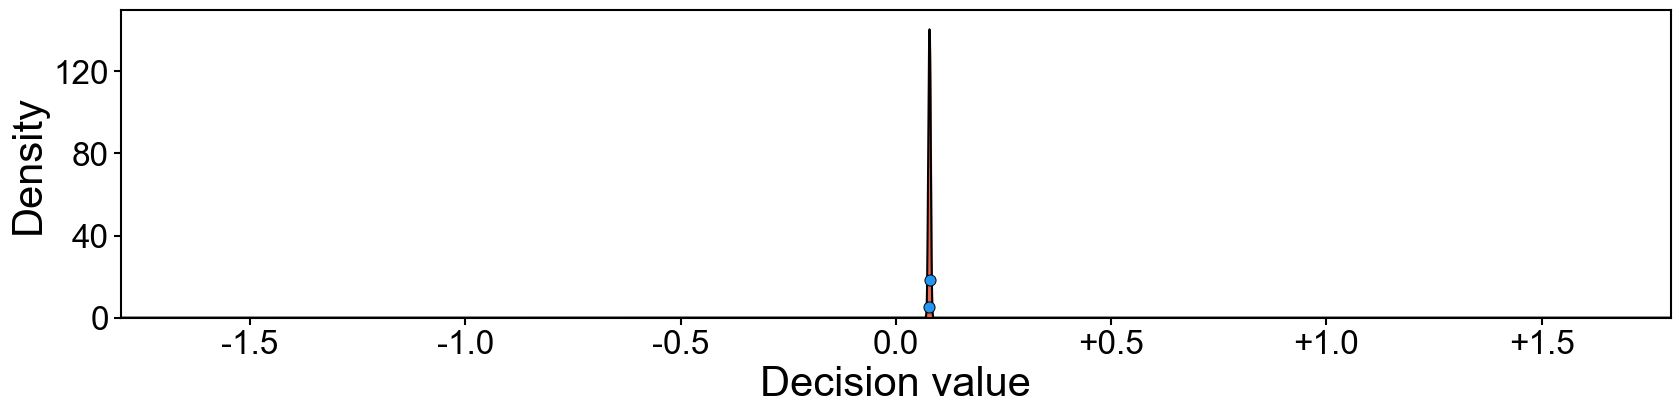

In [129]:
# Extract rows from subset_zoonotic_predict based on the given Brucella inopinata IDs
Brucella_inopinataID=["GCA_000182725.1_ASM18272v1_genomic", "GCA_900095155.1_BR141012304v1_genomic"]

# Filter the DataFrame for the specified Brucella inopinata IDs
subset_brucella_inopinata = subset_zoonotic_predict[subset_zoonotic_predict['ID'].isin(Brucella_inopinataID)]

# Prepare feature matrix by dropping 'zoonotic' and 'ID' columns
X_brucella_inopinata = subset_brucella_inopinata.drop(['zoonotic','ID'],axis = 1)

# Get decision function values from three best SVM models
svm_probs1_brucella_inopinata = best_model_svm_1.decision_function(X_brucella_inopinata)
svm_probs2_brucella_inopinata = best_model_svm_2.decision_function(X_brucella_inopinata)
svm_probs3_brucella_inopinata = best_model_svm_3.decision_function(X_brucella_inopinata)

# Stack the decision function scores for all models
stacked_probs_brucella_inopinata = np.vstack([svm_probs1_brucella_inopinata, svm_probs2_brucella_inopinata, svm_probs3_brucella_inopinata])

# Calculate the mean probability across all models
mean_probs_brucella_inopinata = np.mean(stacked_probs_brucella_inopinata, axis=0)

# Plot kernel density estimation and scatter points for Brucella inopinata samples
fig, ax = plt.subplots(figsize=(20, 4))

# Calculate kernel density estimation
kde_brucella_inopinata = gaussian_kde(mean_probs_brucella_inopinata)
x = np.linspace(-1.8, 1.8, 10000)
y_brucella_inopinata = kde_brucella_inopinata(x)

# Plot KDE curve
ax.plot(x, y_brucella_inopinata, color='black')
ax.set_ylim(0, 150)
ax.set_yticks([0.0, 40, 80, 120])

# Fill negative and positive regions with different colors
plt.fill_between(x, y_brucella_inopinata, where=x<0, color='#00A3EC')
plt.fill_between(x, y_brucella_inopinata, where=x>0, color='#E96953')

# Prepare scatter points distributed along the KDE curve
dot_x = mean_probs_brucella_inopinata
dot_y = []
for i, x in enumerate(dot_x):
    dot_y.append(np.linspace(5, kde_brucella_inopinata(x), num=10)[i % 10]) 

# Plot scatter points
ax.plot(dot_x, dot_y, color='black', marker='o', linestyle='', markersize=8, 
        markerfacecolor = '#2196f3', alpha = 1, markeredgewidth = 0.7)

# Set axis ticks
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tick_params(axis='both', which='major', width=1.5, length=5)

# Set border thickness
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(1.5)

ax.set_xlim(-1.8, 1.8)
ax.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])

# Custom tick formatter: add '+' for positive values
def format_func(x, pos):
    return f'+{x:.1f}' if x > 0 else f'{x:.1f}'
ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xlabel('Decision value', fontsize=30)
ax.set_ylabel('Density', fontsize=30)
plt.show()

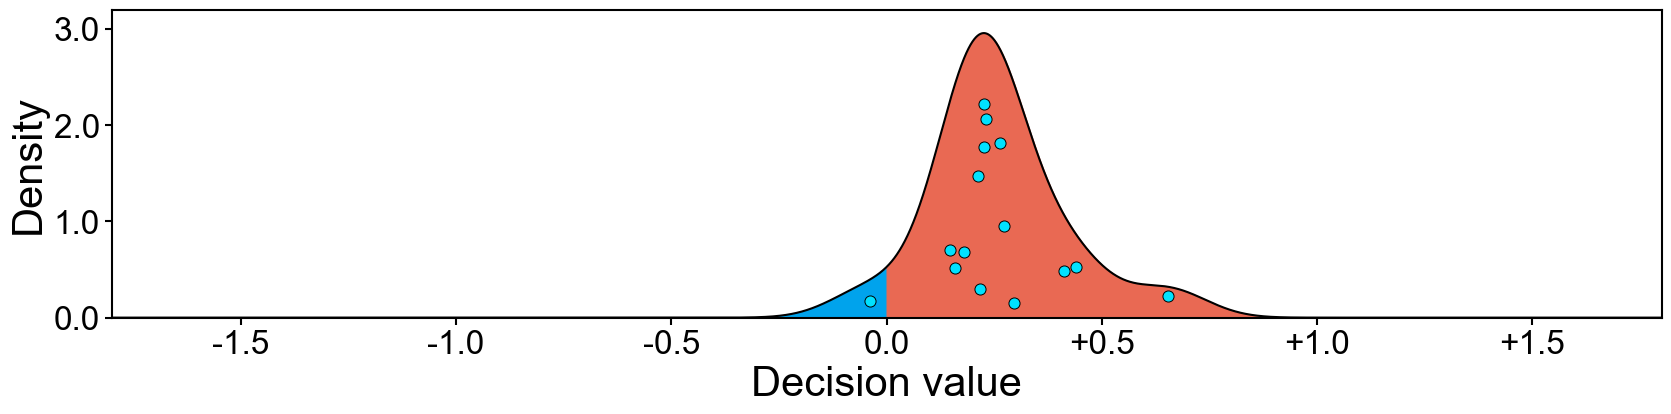

In [130]:
# Extract rows from subset_zoonotic_predict based on the given Brucella suis bv. 2 IDs
Brucella_suis_bv_2ID=[
    "GCA_000018905.1_ASM1890v1_genomic","GCA_000698245.1_ASM69824v1_genomic",
    "GCA_000698285.1_ASM69828v1_genomic","GCA_000698325.1_ASM69832v1_genomic",
    "GCA_000698345.1_ASM69834v1_genomic","GCA_000699025.1_ASM69902v1_genomic",
    "GCA_014884405.1_ASM1488440v1_genomic","GCA_014884425.1_ASM1488442v1_genomic",
    "GCA_014884445.1_ASM1488444v1_genomic","GCA_014884465.1_ASM1488446v1_genomic",
    "GCA_014884585.1_ASM1488458v1_genomic","GCA_904066045.1_WS-Be-68_genomic",
    "GCA_904066055.1_WS-Be-9_genomic","GCA_904066065.1_WS-Be-70_genomic",
    "GCA_904066075.1_WS-Be-61_genomic"
]

# Filter the DataFrame for the specified Brucella suis bv 2 IDs
subset_brucella_suis_bv_2 = subset_zoonotic_predict[subset_zoonotic_predict['ID'].isin(Brucella_suis_bv_2ID)]

# Prepare feature matrix by dropping 'zoonotic' and 'ID' columns
X_brucella_suis_bv_2 = subset_brucella_suis_bv_2.drop(['zoonotic','ID'],axis = 1)

# Get decision function values from three best SVM models
svm_probs1_brucella_suis_bv_2 = best_model_svm_1.decision_function(X_brucella_suis_bv_2)
svm_probs2_brucella_suis_bv_2 = best_model_svm_2.decision_function(X_brucella_suis_bv_2)
svm_probs3_brucella_suis_bv_2 = best_model_svm_3.decision_function(X_brucella_suis_bv_2)

# Stack the decision function scores for all models
stacked_probs_brucella_suis_bv_2 = np.vstack([svm_probs1_brucella_suis_bv_2, svm_probs2_brucella_suis_bv_2, svm_probs3_brucella_suis_bv_2])

# Calculate the mean probability across all models
mean_probs_brucella_suis_bv_2 = np.mean(stacked_probs_brucella_suis_bv_2, axis=0)

# Plot kernel density estimation and scatter points for Brucella suis bv 2 samples
fig, ax = plt.subplots(figsize=(20, 4))

# Calculate kernel density estimation
kde_brucella_suis_bv_2 = gaussian_kde(mean_probs_brucella_suis_bv_2)
x = np.linspace(-1.8, 1.8, 10000)
y_suis_bv_2 = kde_brucella_suis_bv_2(x)

# Plot KDE curve
ax.plot(x, y_suis_bv_2, color='black')
ax.set_ylim(0, 3.2)
ax.set_yticks([0.0, 1.0, 2.0, 3.0])
# Fill negative and positive regions with different colors
plt.fill_between(x, y_suis_bv_2, where=x<0, color='#00A3EC')
plt.fill_between(x, y_suis_bv_2, where=x>0, color='#E96953')

# Prepare scatter points distributed along the KDE curve
dot_x = mean_probs_brucella_suis_bv_2
dot_y = []
for i, x in enumerate(dot_x):
    dot_y.append(np.linspace(0.15, kde_brucella_suis_bv_2(x), num=20)[i % 20]) 

# Plot scatter points
ax.plot(dot_x, dot_y, color='black', marker='o', linestyle='', markersize=8, 
        markerfacecolor = '#00E2FF', alpha = 1, markeredgewidth = 0.7)

# Set axis ticks
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tick_params(axis='both', which='major', width=1.5, length=5)

# Set border thickness
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(1.5)

ax.set_xlim(-1.8, 1.8)
ax.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])

# Custom tick formatter: add '+' for positive values
def format_func(x, pos):
    return f'+{x:.1f}' if x > 0 else f'{x:.1f}'
ax.xaxis.set_major_formatter(FuncFormatter(format_func))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_xlabel('Decision value', fontsize=30)
ax.set_ylabel('Density', fontsize=30)
plt.show()

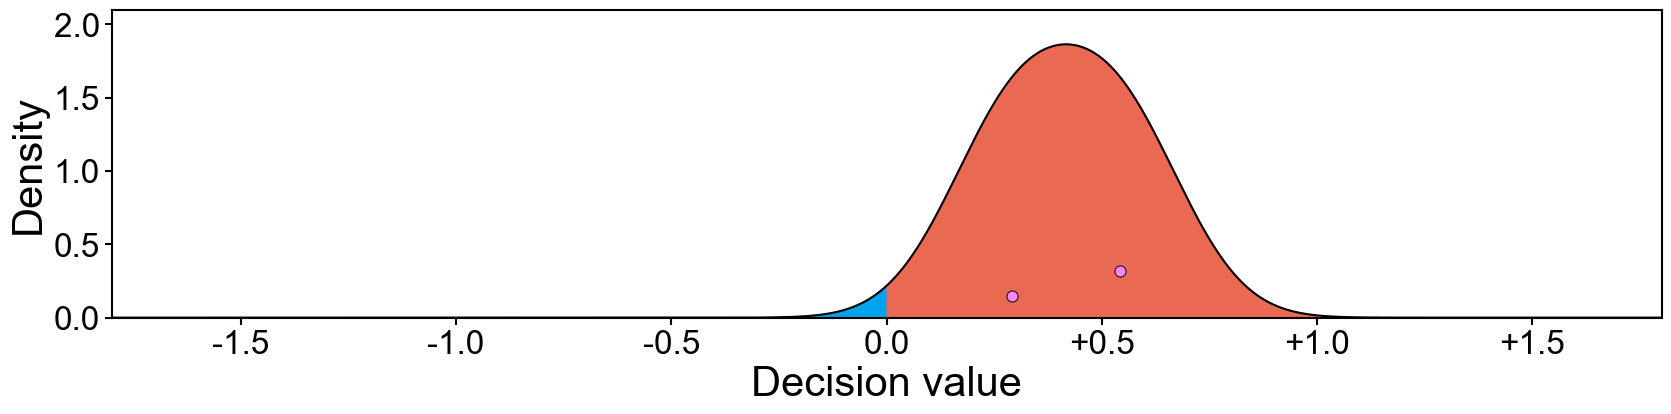

In [131]:
# Extract rows from subset_zoonotic_predict based on the given Brucella suis bv. 4 IDs
Brucella_suis_bv_4ID=["GCA_000160275.1_ASM16027v1_genomic","GCA_014884505.1_ASM1488450v1_genomic"]

# Filter the DataFrame for the specified Brucella suis bv 4 IDs
subset_brucella_suis_bv_4 = subset_zoonotic_predict[subset_zoonotic_predict['ID'].isin(Brucella_suis_bv_4ID)]

# Prepare feature matrix by dropping 'zoonotic' and 'ID' columns
X_brucella_suis_bv_4 = subset_brucella_suis_bv_4.drop(['zoonotic','ID'],axis = 1)

# Get decision function values from three best SVM models
svm_probs1_brucella_suis_bv_4 = best_model_svm_1.decision_function(X_brucella_suis_bv_4)
svm_probs2_brucella_suis_bv_4 = best_model_svm_2.decision_function(X_brucella_suis_bv_4)
svm_probs3_brucella_suis_bv_4 = best_model_svm_3.decision_function(X_brucella_suis_bv_4)


# Stack the decision function scores for all models
stacked_probs_brucella_suis_bv_4 = np.vstack([svm_probs1_brucella_suis_bv_4, svm_probs2_brucella_suis_bv_4, svm_probs3_brucella_suis_bv_4])

# Calculate the mean probability across all models
mean_probs_brucella_suis_bv_4 = np.mean(stacked_probs_brucella_suis_bv_4, axis=0)


# Plot kernel density estimation and scatter points for Brucella suis bv 4 samples
fig, ax = plt.subplots(figsize=(20, 4))

# Calculate kernel density estimation
kde_brucella_suis_bv_4 = gaussian_kde(mean_probs_brucella_suis_bv_4)
x = np.linspace(-1.8, 1.8, 10000)
y_brucella_suis_bv_4 = kde_brucella_suis_bv_4(x)

# Plot KDE curve
ax.plot(x, y_brucella_suis_bv_4, color='black')
ax.set_ylim(0, 2.1)
ax.set_yticks([0.0, 0.5, 1, 1.5, 2.0])

# Fill negative and positive regions with different colors
plt.fill_between(x, y_brucella_suis_bv_4, where=x<0, color='#00A3EC')
plt.fill_between(x, y_brucella_suis_bv_4, where=x>0, color='#E96953')

# Prepare scatter points distributed along the KDE curve
dot_x = mean_probs_brucella_suis_bv_4
dot_y = []
for i, x in enumerate(dot_x):
    dot_y.append(np.linspace(0.15, kde_brucella_suis_bv_4(x), num=10)[i % 10]) 

# Plot scatter points
ax.plot(dot_x, dot_y, color='black', marker='o', linestyle='', markersize=8, 
        markerfacecolor = '#FF83FA', alpha = 1, markeredgewidth = 0.7)

# Set axis ticks
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tick_params(axis='both', which='major', width=1.5, length=5)

# Set border thickness
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(1.5)

ax.set_xlim(-1.8, 1.8)
ax.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])

# Custom tick formatter: add '+' for positive values
def format_func(x, pos):
    return f'+{x:.1f}' if x > 0 else f'{x:.1f}'
ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xlabel('Decision value', fontsize=30)
ax.set_ylabel('Density', fontsize=30)
plt.show()

In [133]:
# Create a DataFrame df_species_host with the index and ID columns from subset_create_model
df_species_host = pd.DataFrame({
    'Index': subset_create_model.index,
    'ID': subset_create_model['ID']
})

# Add a column 'Test_data' to indicate whether each row is in the test set
df_species_host['Test_data'] = df_species_host['Index'].isin(X_test.index)

# Add a column 'Decision_value', mapping mean_probs to the corresponding test indices
s = pd.Series(mean_probs, index=X_test.index, name='Decision_value')
df_species_host['Decision_value'] = df_species_host['Index'].map(s)

# Add new rows for predicted Brucella strains, with Index and Test_data set to False
new_rows_list = [
    pd.DataFrame({
        'Index': [False] * len(Brucella_suis_bv_4ID),
        'ID': Brucella_suis_bv_4ID,
        'Test_data': [False] * len(Brucella_suis_bv_4ID),
        'Decision_value': mean_probs_brucella_suis_bv_4
    }),
    pd.DataFrame({
        'Index': [False] * len(Brucella_suis_bv_2ID),
        'ID': Brucella_suis_bv_2ID,
        'Test_data': [False] * len(Brucella_suis_bv_2ID),
        'Decision_value': mean_probs_brucella_suis_bv_2
    }),
    pd.DataFrame({
        'Index': [False] * len(Brucella_inopinataID),
        'ID': Brucella_inopinataID,
        'Test_data': [False] * len(Brucella_inopinataID),
        'Decision_value': mean_probs_brucella_inopinata
    }),
    pd.DataFrame({
        'Index': [False] * len(Brucella_vulpisID),
        'ID': Brucella_vulpisID,
        'Test_data': [False] * len(Brucella_vulpisID),
        'Decision_value': mean_probs_brucella_vulpis
    }),
    pd.DataFrame({
        'Index': [False] * len(Brucella_microtiID),
        'ID': Brucella_microtiID,
        'Test_data': [False] * len(Brucella_microtiID),
        'Decision_value': mean_probs_brucella_microti
    }),
    pd.DataFrame({
        'Index': [False] * len(Brucella_neotomaeID),
        'ID': Brucella_neotomaeID,
        'Test_data': [False] * len(Brucella_neotomaeID),
        'Decision_value': mean_probs_brucella_neotomae
    }),
    pd.DataFrame({
        'Index': [False] * len(Brucella_pinnipedialisID),
        'ID': Brucella_pinnipedialisID,
        'Test_data': [False] * len(Brucella_pinnipedialisID),
        'Decision_value': mean_probs_brucella_pinnipedialis
    }),
    pd.DataFrame({
        'Index': [False] * len(Brucella_cetiID),
        'ID': Brucella_cetiID,
        'Test_data': [False] * len(Brucella_cetiID),
        'Decision_value': mean_probs_brucella_ceti
    }),
    pd.DataFrame({
        'Index': [False] * len(Brucella_canisID),
        'ID': Brucella_canisID,
        'Test_data': [False] * len(Brucella_canisID),
        'Decision_value': mean_probs_brucella_canis
    }),
]

# Concatenate all new rows and append to df_species_host
all_new_rows = pd.concat(new_rows_list, ignore_index=True)
df_species_host = pd.concat([df_species_host, all_new_rows], ignore_index=True)

# Construct absolute path to data file
Species_host_of_Brucella_strains = os.path.join(script_dir, 'Data', 'Species host of Brucella strains.xlsx')

# Read the Information of Brucella strain.xlsx file
info_df = pd.read_excel(Species_host_of_Brucella_strains)

# Merge Decision_value from df_species_host into info_df, similar to VLOOKUP
info_df = info_df.merge(
    df_species_host[['ID', 'Decision_value']],
    left_on='Brucella_strain_genome_GenBank_number',
    right_on='ID',
    how='left'
)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


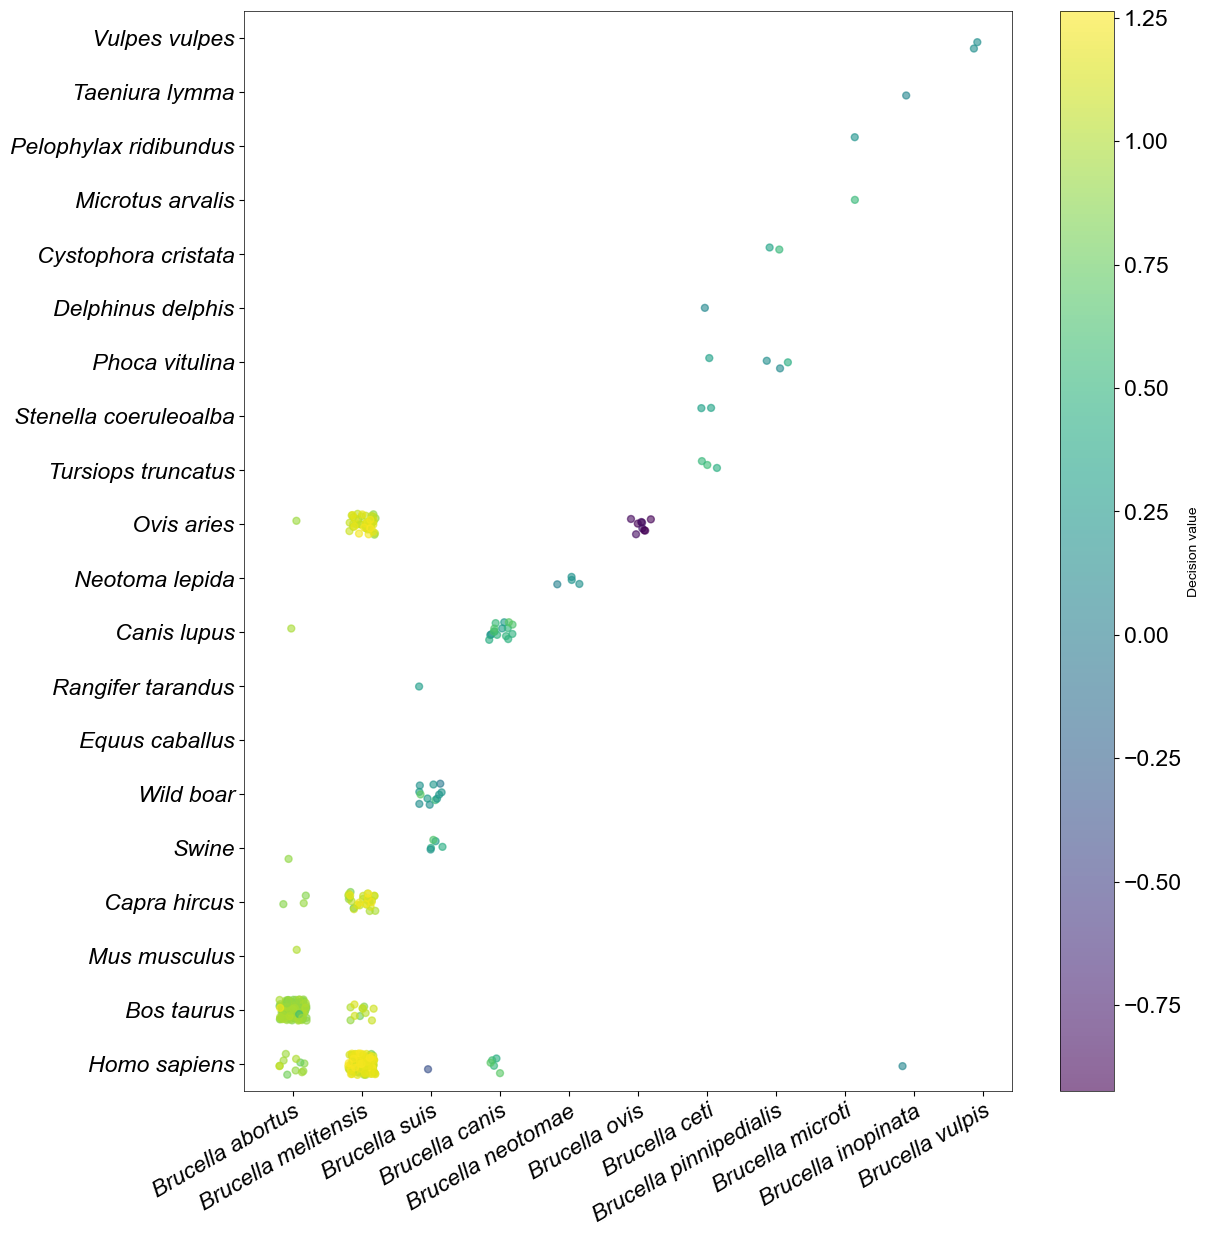

In [96]:
# Remove rows with missing or #N/A values in 'Decision_value'
info_df_cleaned = info_df.dropna(subset=['Decision_value'])

# Define custom host order for y-axis
custom_host_order = [
    'Homo sapiens', 'Bos taurus', 'Mus musculus', 'Capra hircus', 'Swine', 'Wild boar', 'Equus caballus',
    'Rangifer tarandus', 'Canis lupus', 'Neotoma lepida', 'Ovis aries', 'Tursiops truncatus', 'Stenella coeruleoalba',
    'Phoca vitulina', 'Delphinus delphis', 'Cystophora cristata', 'Microtus arvalis', 'Pelophylax ridibundus',
    'Taeniura lymma', 'Vulpes vulpes'
]

# Convert 'Standardized_isolate_source' to a categorical type with the custom order
info_df_cleaned['Standardized_isolate_source'] = pd.Categorical(
    info_df_cleaned['Standardized_isolate_source'],
    categories=custom_host_order,
    ordered=True
)

# Filter out unwanted host categories
exclude_hosts = [
    'Not available', 'Ovis aries/Capra hircus', 'Environment',
    'environmental', 'marine mammals', 'Phocoena'
]
info_df_filtered = info_df_cleaned[
    ~info_df_cleaned['Standardized_isolate_source'].isin(exclude_hosts)
]

# Define custom species order for x-axis
custom_species_order = [
    'Brucella_abortus', 'Brucella_melitensis', 'Brucella_suis',
    'Brucella_canis', 'Brucella_neotomae', 'Brucella_ovis',
    'Brucella_ceti', 'Brucella_pinnipedialis', 'Brucella_microti',
    'Brucella_inopinata', 'Brucella_vulpis'
]

# Convert 'Species' to a categorical type with the custom order
info_df_filtered['Species'] = pd.Categorical(
    info_df_filtered['Species'],
    categories=custom_species_order,
    ordered=True
)

# Encode species and host as integer labels for plotting
species_labels = info_df_filtered['Species'].cat.codes
host_labels = info_df_filtered['Standardized_isolate_source'].cat.codes

# Add jitter to avoid overlapping points
jitter_strength = 0.2
species_jittered = species_labels + np.random.uniform(-jitter_strength, jitter_strength, size=len(species_labels))
host_jittered = host_labels + np.random.uniform(-jitter_strength, jitter_strength, size=len(host_labels))

# Create scatter plot
plt.figure(figsize=(12, 12))

# Set font to Arial
plt.rcParams['font.family'] = 'Arial'
scatter = plt.scatter(
    species_jittered, host_jittered,
    c=info_df_filtered['Decision_value'], s=25, alpha=0.6
)

# Add colorbar
cbar = plt.colorbar(scatter)

 # Set colorbar tick label size
cbar.ax.tick_params(labelsize=16.5) 
cbar.set_label('Decision value')

# Set x-tick labels: replace '_' with ' ', italic, larger font
species_labels_with_spaces = [s.replace('_', ' ') for s in custom_species_order]
plt.xticks(
    ticks=np.arange(len(custom_species_order)),
    labels=species_labels_with_spaces,
    rotation=30, rotation_mode='anchor', ha='right',
    fontstyle='italic', fontsize=16.5
)

# Set y-tick labels: italic, larger font
plt.yticks(
    ticks=np.arange(len(custom_host_order)),
    labels=custom_host_order,
    fontstyle='italic', fontsize=16.5
)

# Set y-axis limits to avoid clipping
plt.ylim(-0.5, len(custom_host_order) - 0.5)

# Adjust subplot margins
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.05)
plt.show()

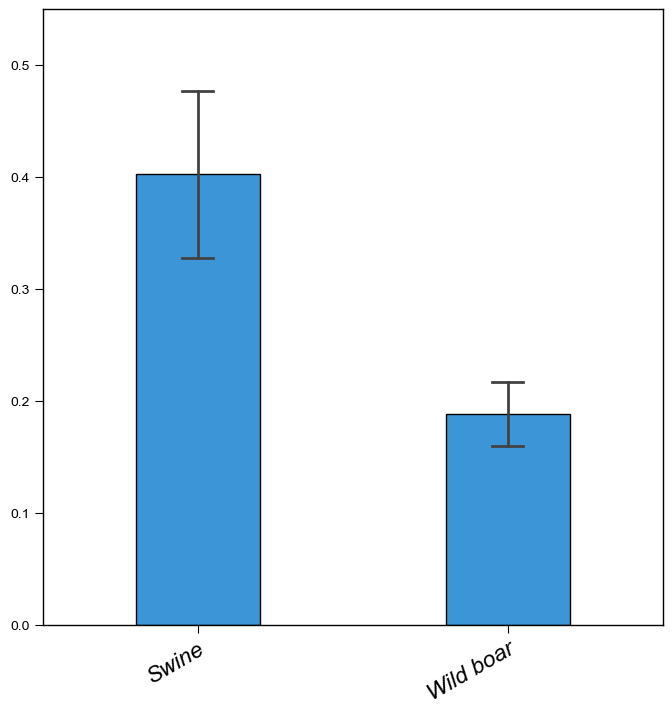

In [ ]:
# Retain only the 'Decision_value' column and convert to list for Brucella suis bv.2 from Swine
Brucella_suis_bv_2_swine = info_df[
    (info_df['Species'] == 'Brucella_suis') &
    (info_df['Biovar'] == 2) &
    (info_df['Standardized_isolate_source'] == 'Swine')
]['Decision_value'].dropna().tolist()

# Retain only the 'Decision_value' column and convert to list for Brucella suis bv.2 from Wild boar
Brucella_suis_bv_2_wild_boar = info_df[
    (info_df['Species'] == 'Brucella_suis') &
    (info_df['Biovar'] == 2) &
    (info_df['Standardized_isolate_source'] == 'Wild boar')
]['Decision_value'].dropna().tolist()

# Combine data for plotting
fig_7D_data = [Brucella_suis_bv_2_swine, Brucella_suis_bv_2_wild_boar]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Set font to Arial
plt.rcParams['font.family'] = 'Arial'

# Set color for the bars
fig_7D_color = ["#2299f1"]

# Draw barplot with standard error
sns.barplot(
    data=fig_7D_data, ax=ax, palette=fig_7D_color, width=0.4, 
    errorbar="se", capsize=0.1, errwidth=2, edgecolor='black'
)

# Set y-axis range
ax.set_ylim(0.0, 0.55)

# Thicken all plot borders
plt.gca().spines['top'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['right'].set_linewidth(1)

# Adjust axis tick width and length
plt.tick_params(axis='both', which='major', length=6)

# Set y-axis labels
plt.xticks(
    [0, 1], 
    ['Swine', 'Wild boar'], 
    fontsize=16.5, rotation=30, rotation_mode='anchor', ha='right', fontstyle='italic'
)
plt.show()

In [97]:
# Read the Excel file containing species and decision values
species_df_path = os.path.join(script_dir, 'Data', 'Decision_value_species_host.xlsx')
species_df = pd.read_excel(species_df_path)

# Define the grouping column and value column
group_col = 'species'
value_col = 'decision_value'

# Get unique groups and extract values for each group
groups = species_df[group_col].unique()
data = [species_df[species_df[group_col] == group][value_col] for group in groups]

# Define the statistic function: mean difference between two groups
def stat_func(x, y):
    return np.mean(x) - np.mean(y)

# Get all pairwise combinations of groups (with group names and data)
group_combinations = list(combinations(zip(groups, data), 2))

# Store p-values and combination names
p_values = []
combinations_names = []

# Perform permutation test for each pairwise group comparison
for (name1, group1), (name2, group2) in group_combinations:
    res = stats.permutation_test([group1, group2],
                                 statistic=stat_func, 
                                 n_resamples=10000, 
                                 alternative='two-sided', 
                                 random_state=1)
    p_values.append(res.pvalue)
    combinations_names.append(f'{name1} - {name2}')

# Adjust p-values using the Benjamini-Hochberg method (FDR correction)
corrected_p_values_bh = multipletests(p_values, method='fdr_bh')[1]

# Print the corrected p-values
print("Benjamini-Hochberg corrected p-values:")
for i, p_val in enumerate(corrected_p_values_bh):
    print(f'{combinations_names[i]}: {p_val:.5f}')

# Save the corrected p-values to a text file
with open('corrected_p_values.txt', 'w') as f:
    f.write("Benjamini-Hochberg corrected p-values:\n")
    for i, p_val in enumerate(corrected_p_values_bh):
        f.write(f'{combinations_names[i]}: {p_val:.5f}\n')

print("Corrected p-values have been saved to 'corrected_p_values.txt'.")

Benjamini-Hochberg corrected p-values:
1 - 4: 0.00067
1 - 7: 0.00067
1 - 10: 0.00067
1 - 2: 0.00067
1 - 9: 0.00067
1 - 5: 0.00067
1 - 6: 0.00067
1 - 8: 0.00067
1 - 3: 0.00067
1 - 11: 0.00067
4 - 7: 0.22473
4 - 10: 0.01610
4 - 2: 0.00067
4 - 9: 0.48007
4 - 5: 0.00396
4 - 6: 0.00067
4 - 8: 0.11387
4 - 3: 0.00229
4 - 11: 0.04598
7 - 10: 0.09259
7 - 2: 0.00067
7 - 9: 0.94444
7 - 5: 0.04598
7 - 6: 0.00100
7 - 8: 0.61625
7 - 3: 0.33909
7 - 11: 0.23504
10 - 2: 0.00100
10 - 9: 0.40373
10 - 5: 0.46809
10 - 6: 0.06250
10 - 8: 0.14966
10 - 3: 0.28571
10 - 11: 0.40373
2 - 9: 0.00100
2 - 5: 0.00067
2 - 6: 0.00067
2 - 8: 0.00067
2 - 3: 0.00067
2 - 11: 0.00100
9 - 5: 0.20370
9 - 6: 0.06250
9 - 8: 0.69182
9 - 3: 0.61625
9 - 11: 0.40373
5 - 6: 0.00592
5 - 8: 0.22974
5 - 3: 0.40373
5 - 11: 0.81481
6 - 8: 0.00229
6 - 3: 0.00067
6 - 11: 0.06250
8 - 3: 0.68807
8 - 11: 0.61625
3 - 11: 0.40373
Corrected p-values have been saved to 'corrected_p_values.txt'.


Setting the 'color' property will override the edgecolor or facecolor properties.


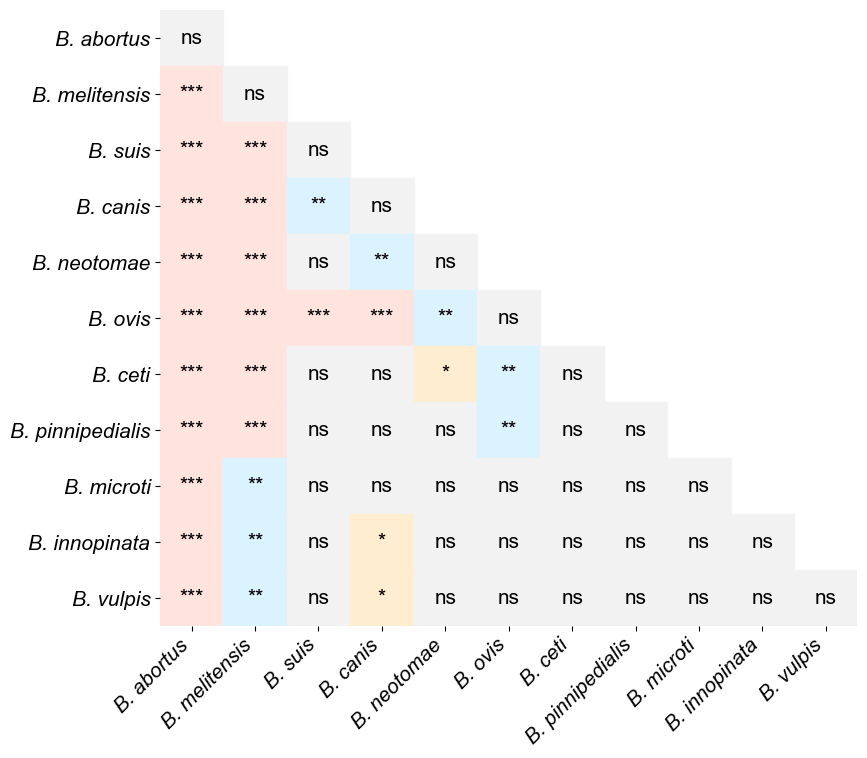

In [ ]:
# Read the corrected p-values from the text file
with open('corrected_p_values.txt', 'r') as file:
    file_content = file.read()

# Regular expression to extract group indices and p-values
pattern = r"(\d+) - (\d+): ([\d.]+)"
matches = re.findall(pattern, file_content)

# Convert matches to a DataFrame
df = pd.DataFrame(matches, columns=['Group 1', 'Group 2', 'P-value'])
df['Group 1'] = df['Group 1'].astype(int)
df['Group 2'] = df['Group 2'].astype(int)
df['P-value'] = df['P-value'].astype(float)

# Define custom labels for x and y axes
custom_labels = ['B. abortus', 'B. melitensis', 'B. suis', 'B. canis', 'B. neotomae', 'B. ovis', 
                 'B. ceti', 'B. pinnipedialis', 'B. microti', 'B. innopinata', 'B. vulpis']

# Determine the size of the matrix
matrix_size = len(custom_labels)
# Initialize the heatmap data matrix with 1 (default p-value)
heatmap_data = np.ones((matrix_size, matrix_size))

# Fill the matrix with p-values from the DataFrame
for _, row in df.iterrows():
    group1 = int(row['Group 1']) - 1
    group2 = int(row['Group 2']) - 1
    # Check if indices are within matrix range
    if group1 < matrix_size and group2 < matrix_size:
        heatmap_data[group1, group2] = row['P-value']
        heatmap_data[group2, group1] = row['P-value']

# Custom color mapping function for p-values
def p_value_to_color(p_value):
    if p_value >= 0.05:
        return '#f2f2f2'  # Gray for not significant
    elif 0.01 <= p_value < 0.05:
        return '#ffedd0'  # Light orange for 0.01 <= p < 0.05
    elif 0.001 <= p_value < 0.01:
        return '#dbf2ff'  # Light blue for 0.001 <= p < 0.01
    else:
        return '#ffe4de'  # Light red for p < 0.001

# Create a color matrix for the heatmap
color_matrix = np.empty_like(heatmap_data, dtype=object)
for i in range(matrix_size):
    for j in range(matrix_size):
        color_matrix[i, j] = p_value_to_color(heatmap_data[i, j])

# Create a mask to show only the lower triangle of the matrix
mask = np.triu(np.ones_like(heatmap_data, dtype=bool), k=1)

plt.figure(figsize=(9, 8))

# Function to convert p-value to significance label
def p_value_to_label(p_value):
    if p_value >= 0.05:
        return "ns"
    elif 0.01 <= p_value < 0.05:
        return "*"
    elif 0.001 <= p_value < 0.01:
        return "**"
    else:
        return "***"

# Draw each cell in the lower triangle with the corresponding color and label
for i in range(matrix_size):
    for j in range(matrix_size):
        if i >= j:  # Only plot lower triangle
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='gray'))
            plt.text(j + 0.5, i + 0.5, p_value_to_label(heatmap_data[i, j]), ha='center', va='center', fontsize=15)

plt.xlim(0, matrix_size)
plt.ylim(0, matrix_size)

# Remove all borders around the heatmap
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Set axis ticks and labels
plt.xticks(np.arange(0.5, matrix_size, 1), custom_labels, rotation=45, ha='right', fontstyle='italic', fontname='Arial', fontsize=15)
plt.yticks(np.arange(0.5, matrix_size, 1), custom_labels, fontstyle='italic', fontname='Arial', fontsize=15)

plt.gca().invert_yaxis()  # Invert y-axis for matrix layout
plt.show()


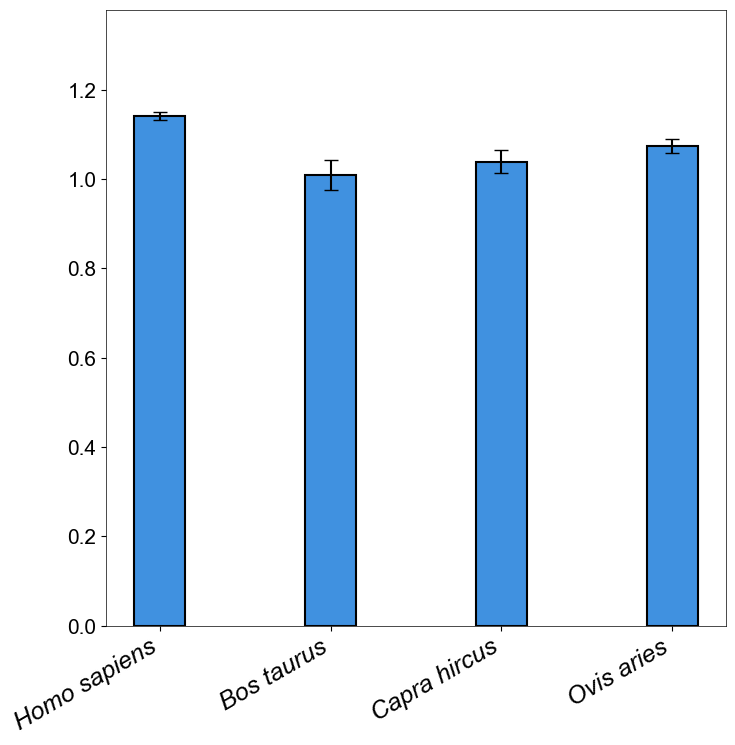

In [102]:
def filter_and_plot_mean_bar_with_se(species_df_path, species_value, host_values):
    """
    Filter data by species and host, then plot the mean and standard error of decision values as a bar plot.

    Args:
        species_df_path (str): Path to the Excel file containing species and host decision values.
        species_value (int): The species code to filter.
        host_values (str): Host codes separated by '-', e.g., '1-2-4'.
    """
    # Mapping from host code to host name
    host_mapping = {
    1: 'Homo sapiens',
    2: 'Bos taurus',
    3: 'Mus musculus',
    4: 'Capra hircus',
    5: 'Swine',
    6: 'Wild boar',
    7: 'Equus caballus',
    8: 'Rangifer tarandus',
    9: 'Canis lupus',
    10: 'Neotoma lepida',
    11: 'Ovis aries',
    12: 'Tursiops truncatus',
    13: 'Stenella coeruleoalba',
    14: 'Phoca vitulina',
    15: 'Delphinus delphis',
    16: 'Cystophora cristata',
    17: 'Microtus arvalis',
    18: 'Pelophylax ridibundus',
    19: 'Taeniura lymma',
    20: 'Vulpes vulpes',
}
    # Read Excel file
    df = pd.read_excel(species_df_path)
    
    # Ensure host_values is a list of integers (e.g., "1-2-4" -> [1, 2, 4])
    host_values = list(map(int, host_values.split('-')))
    
    # Filter data by species and host
    filtered_data = df[(df['species'] == species_value) & (df['host'].isin(host_values))]
    
    if not filtered_data.empty:
        # Group by host and calculate mean and standard error
        mean_values = filtered_data.groupby('host')['decision_value'].mean()
        se_values = filtered_data.groupby('host')['decision_value'].sem()
        
        # Create evenly spaced x positions for the bars
        x_positions = np.arange(len(host_values))
        
        # Get host names for x-axis labels
        host_labels = [host_mapping.get(host, f'Host {host}') for host in host_values]
        
        # Plot bar chart with error bars
        fig, ax = plt.subplots(figsize=(8, 8))
        plt.rcParams['font.family'] = 'Arial'
        bars = ax.bar(x_positions, mean_values, yerr=se_values, capsize=5, 
                      color='#4091e0', edgecolor='black', linewidth=1.5, width=0.3)
        
        # Add extra space above the bars
        ax.set_ylim(0, max(mean_values + se_values) * 1.2)

        # Set x-axis labels: italic, Arial font
        plt.xticks(x_positions, host_labels, fontname='Arial', fontsize=18, fontstyle='italic', rotation=30, ha='right')

        # Set y-axis tick label size
        ax.tick_params(axis='y', labelsize=15)
        plt.show()
filter_and_plot_mean_bar_with_se(species_df_path, 2, '1-2-4-11')

In [ ]:
# Get the list of feature names from the resampled training set
feature_names = X_train_resampled.columns.tolist()

# Put the best SVM models into a list
best_svm_model_list = [best_model_svm_1, best_model_svm_2, best_model_svm_3]

# Generate summary background data using shap.kmeans (select 100 representative samples)
background_summary = shap.kmeans(X_train_resampled, 100)

# Use SHAP's KernelExplainer to explain each model's decision function
explainers = [shap.KernelExplainer(model.decision_function, background_summary) for model in best_svm_model_list]

# Calculate SHAP values for each model on the test set
shap_values_test = [explainer.shap_values(X_test, features=X_test.columns) for explainer in explainers]

# Average the SHAP value matrices across all models
avg_shap_values_test = sum(shap_values_test) / len(shap_values_test)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
100%|██████████| 442/442 [08:16<00:00,  1.12s/it]


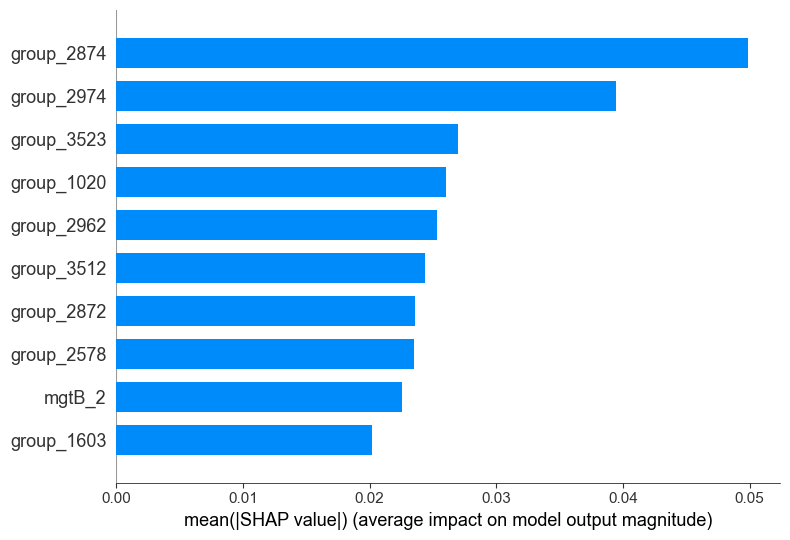

In [120]:
# Use the average SHAP values to interpret model results
shap.initjs()

# Draw a bar summary plot of the top 10 features ranked by mean absolute SHAP value
shap.summary_plot(
    avg_shap_values_test,
    X_test,
    plot_type="bar",
    max_display=10,    
    show=False
)
plt.show()

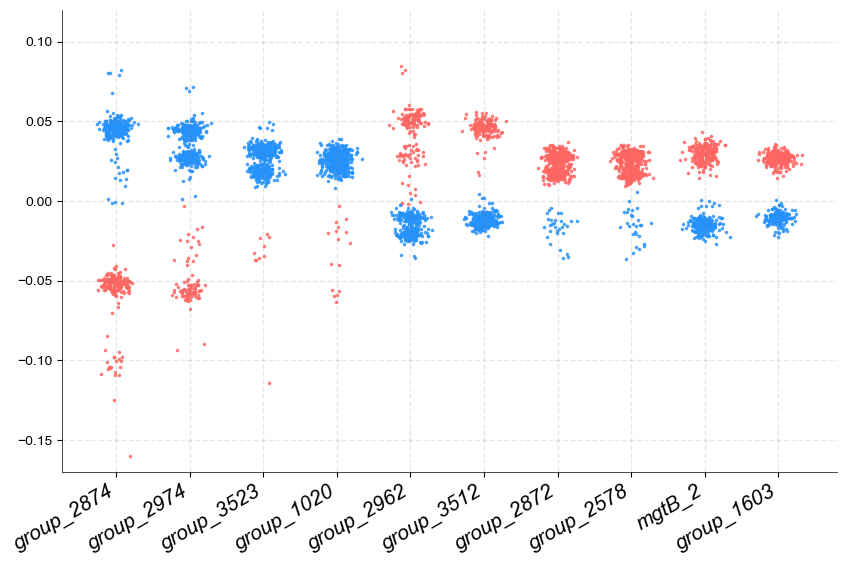

In [112]:
# Select the indices of the top 10 features ranked by mean absolute SHAP value
top10_features_index = sorted(
    range(len(avg_shap_values_test[0])),
    key=lambda i: -np.abs(avg_shap_values_test[:, i]).mean()
)[:10]

# Extract the feature matrix and SHAP values for the top 10 features
top10_features_data = X_test.iloc[:, top10_features_index]
avg_shap_values_test_df = pd.DataFrame(avg_shap_values_test)
top10_shap_values = avg_shap_values_test_df.iloc[:, top10_features_index]

# Get the feature names for the x-axis labels
top10_feature_names = X_test.columns[top10_features_index]

# Create scatter plot for SHAP values of the top 10 features
plt.figure(figsize=(10, 6))
num_cols = len(top10_features_data.columns)
for i in range(num_cols):
    shap_values_col = top10_shap_values.iloc[:, i]
    feature_data_col = top10_features_data.iloc[:, i]
    # Add jitter to x-axis for better visualization
    x_values = np.random.normal(i, 0.1, size=len(shap_values_col))
    for j, (shap_val, feature_val) in enumerate(zip(shap_values_col, feature_data_col)):
        color = '#2591fa' if feature_val == 0 else '#ff6561'
        plt.scatter(x_values[j], shap_val, color=color, alpha=0.75, s=2.5)

# Set x-axis labels as top 10 feature names, italic and rotated 30 degrees
plt.xticks(
    ticks=range(num_cols),
    labels=[f"{name}" for name in top10_feature_names],
    fontstyle='italic',
    fontname='Arial',
    rotation=30,
    ha='right',
    fontsize=15
)

# Set y-axis range
plt.ylim(-0.17, 0.12)

# Add gray dashed grid lines
plt.grid(
    True,
    linestyle='--',
    linewidth=1,
    color='gray',
    alpha=0.2
)

# Hide top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

In [ ]:
# Calculate the average expected value across all explainers as the base value
base_value = sum([explainer.expected_value for explainer in explainers]) / len(explainers)

# Generate a SHAP force plot for the test set and save as HTML
force_plot = shap.force_plot(base_value, avg_shap_values_test, X_test, show=False)
shap.save_html('shap force plot.html', force_plot)

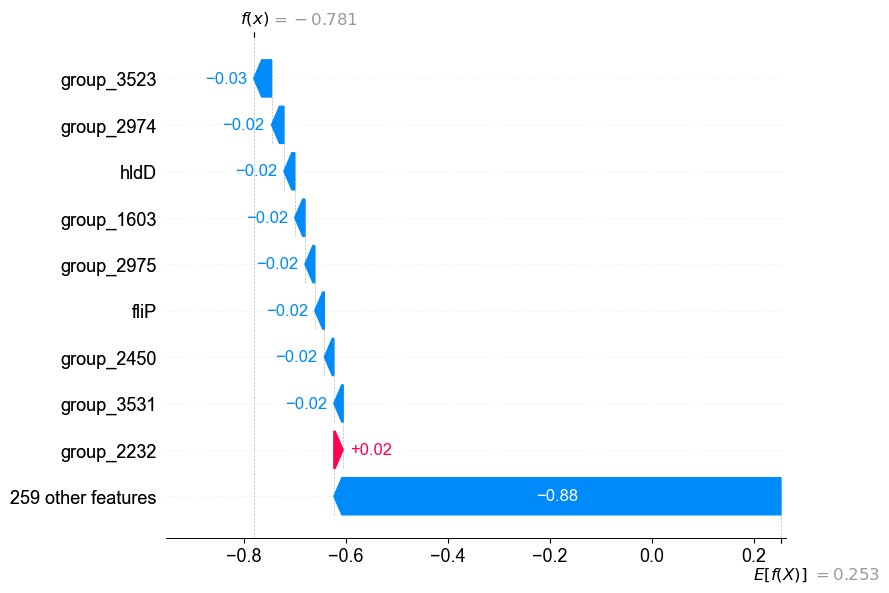

In [ ]:
# Convert avg_shap_values_test to a SHAP Explanation object for local interpretation
explanation_avg_shap_values_test = shap.Explanation(
    avg_shap_values_test,
    base_values=base_value,
    feature_names=X_test.columns
)

# Plot local SHAP waterfall for a non-zoonotic sample (B. ovis ATCC 25840 strain)
shap.plots.waterfall(explanation_avg_shap_values_test[196], max_display=10, show=False)
plt.show()

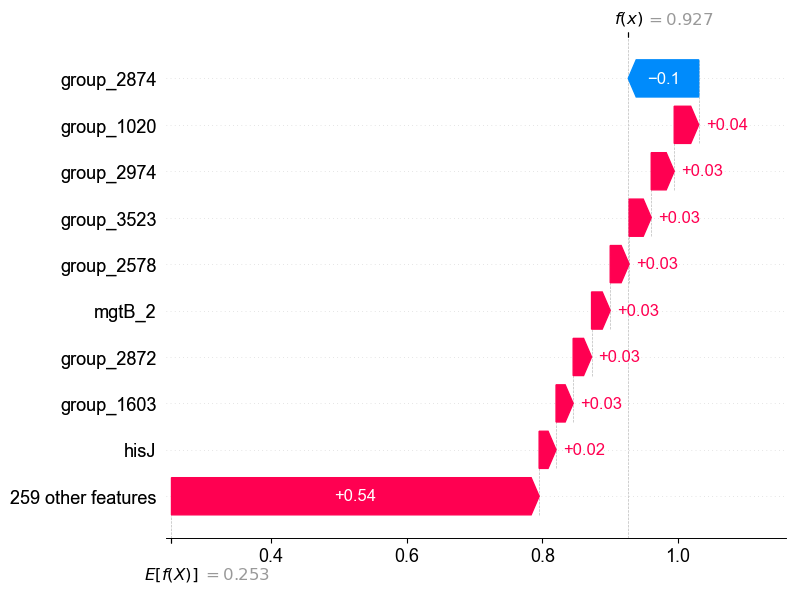

In [ ]:
# Plot local SHAP waterfall for a zoonotic sample (B. melitensis 16M strain)
shap.plots.waterfall(explanation_avg_shap_values_test[205], max_display=10, show=False)
plt.show()